In [32]:
from abc import ABCMeta, abstractmethod
from __future__ import print_function, division
import numpy as np
import scipy
import scipy.stats as stats
import tensorflow as tf
import time

import os
import math

import skimage as ski
import skimage.io

from im2col_cython import col2im_cython, im2col_cython

import _pickle as pickle
import matplotlib.pyplot as plt

## 1. ZADATAK

Dovršite implementacije potpuno povezanog sloja, sloja nelinearnosti te funkcije gubitka u razredima FC, ReLU i SoftmaxCrossEntropyWithLogits.

## Layer implementations

In [2]:
zero_init = np.zeros

def variance_scaling_initializer(shape, fan_in, factor=2.0, seed=None):
    sigma = np.sqrt(factor / fan_in)
    return stats.truncnorm(-2, 2, loc=0, scale=sigma).rvs(shape)


# -- ABSTRACT CLASS DEFINITION --
class Layer(metaclass = ABCMeta):
    "Interface for layers"
    # See documentation of abstract base classes (ABC): https://docs.python.org/3/library/abc.html

    @abstractmethod
    def forward(self, inputs):
        """
        Args:
          inputs: ndarray tensor.
        Returns:
          ndarray tensor, result of the forward pass.
        """
        pass

    @abstractmethod
    def backward_inputs(self, grads):
        """
        Args:
          grads: gradient of the loss with respect to the output of the layer.
        Returns:
          Gradient of the loss with respect to the input of the layer.
        """
        pass

    def backward_params(self, grads):
        """
        Args:
          grads: gradient of the loss with respect to the output of the layer.
        Returns:
          Gradient of the loss with respect to all the parameters of the layer as a list
          [[w0, g0], ..., [wk, gk], self.name] where w are parameter weights and g their gradient.
          Note that wk and gk must have the same shape.
        """
        pass


# -- CONVOLUTION LAYER --
class Convolution(Layer):
    "N-dimensional convolution layer"

    def __init__(self, input_layer, num_filters, kernel_size, name, padding='SAME',
               weights_initializer_fn=variance_scaling_initializer,
               bias_initializer_fn=zero_init):
        self.input_shape = input_layer.shape
        N, C, H, W = input_layer.shape
        self.C = C
        self.N = N
        self.num_filters = num_filters
        self.kernel_size = kernel_size

        assert kernel_size % 2 == 1

        self.padding = padding

        if padding == 'SAME':
            # with zero padding
            self.shape = (N, num_filters, H, W)
            self.pad = (kernel_size - 1) // 2
        else:
            # without padding
            self.shape = (N, num_filters, H - kernel_size + 1, W - kernel_size + 1)
            self.pad = 0

        fan_in = C * kernel_size**2
        self.weights = weights_initializer_fn([num_filters, kernel_size**2 * C], fan_in)
        self.bias = bias_initializer_fn([num_filters])
        # this implementation doesn't support strided convolutions
        self.stride = 1
        self.name = name
        self.has_params = True

    def forward(self, x):
        k = self.kernel_size
        self.x_cols = im2col_cython(x, k, k, self.pad, self.stride)
        res = self.weights.dot(self.x_cols) + self.bias.reshape(-1, 1)
        N, C, H, W = x.shape
        out = res.reshape(self.num_filters, self.shape[2], self.shape[3], N)
        return out.transpose(3, 0, 1, 2)

    def backward_inputs(self, grad_out):
        # nice trick from CS231n, backward pass can be done with just matrix mul and col2im
        grad_out = grad_out.transpose(1, 2, 3, 0).reshape(self.num_filters, -1)
        grad_x_cols = self.weights.T.dot(grad_out)
        N, C, H, W = self.input_shape
        k = self.kernel_size
        grad_x = col2im_cython(grad_x_cols, N, C, H, W, k, k, self.pad, self.stride)
        return grad_x

    def backward_params(self, grad_out):
        grad_bias = np.sum(grad_out, axis=(0, 2, 3))
        grad_out = grad_out.transpose(1, 2, 3, 0).reshape(self.num_filters, -1)
        grad_weights = grad_out.dot(self.x_cols.T).reshape(self.weights.shape)
        return [[self.weights, grad_weights], [self.bias, grad_bias], self.name]


class MaxPooling(Layer):
    def __init__(self, input_layer, name, pool_size=2, stride=2):
        self.name = name
        self.input_shape = input_layer.shape
        N, C, H, W = self.input_shape
        self.stride = stride
        self.shape = (N, C, H // stride, W // stride)
        self.pool_size = pool_size
        assert pool_size == stride, 'Invalid pooling params'
        assert H % pool_size == 0
        assert W % pool_size == 0
        self.has_params = False

    def forward(self, x):
        N, C, H, W = x.shape
        self.input_shape = x.shape
        # with this clever reshaping we can implement pooling where pool_size == stride
        self.x = x.reshape(N, C, H // self.pool_size, self.pool_size,
                           W // self.pool_size, self.pool_size)
        self.out = self.x.max(axis=3).max(axis=4)
        # if you are returning class member be sure to return a copy
        return self.out.copy()

    def backward_inputs(self, grad_out):
        grad_x = np.zeros_like(self.x)
        out_newaxis = self.out[:, :, :, np.newaxis, :, np.newaxis]
        mask = (self.x == out_newaxis)
        dout_newaxis = grad_out[:, :, :, np.newaxis, :, np.newaxis]
        dout_broadcast, _ = np.broadcast_arrays(dout_newaxis, grad_x)
        # this is almost the same as the real backward pass
        grad_x[mask] = dout_broadcast[mask]
        # in the very rare case that more then one input have the same max value
        # we can aprox the real gradient routing by evenly distributing across multiple inputs
        # but in almost all cases this sum will be 1
        grad_x /= np.sum(mask, axis=(3, 5), keepdims=True)
        grad_x = grad_x.reshape(self.input_shape)
        return grad_x


class Flatten(Layer):
    def __init__(self, input_layer, name):
        self.input_shape = input_layer.shape
        self.N = self.input_shape[0]
        self.num_outputs = 1
        for i in range(1, len(self.input_shape)):
            self.num_outputs *= self.input_shape[i]
        self.shape = (self.N, self.num_outputs)
        self.has_params = False
        self.name = name

    def forward(self, inputs):
        self.input_shape = inputs.shape
        inputs_flat = inputs.reshape(self.input_shape[0], -1)
        self.shape = inputs_flat.shape
        return inputs_flat

    def backward_inputs(self, grads):
        return grads.reshape(self.input_shape)


class FC(Layer):
    def __init__(self, input_layer, num_outputs, name,
               weights_initializer_fn=variance_scaling_initializer,
               bias_initializer_fn=zero_init):
        """
        Args:
          input_layer: layer below
          num_outputs: number of neurons in this layer
          weights_initializer_fn: initializer function for weights,
          bias_initializer_fn: initializer function for biases
        """

        self.input_shape = input_layer.shape
        self.N = self.input_shape[0]
        self.shape = (self.N, num_outputs)
        self.num_outputs = num_outputs

        self.num_inputs = 1
        for i in range(1, len(self.input_shape)):
            self.num_inputs *= self.input_shape[i]

        self.weights = weights_initializer_fn([num_outputs, self.num_inputs], fan_in=self.num_inputs)
        self.bias = bias_initializer_fn([num_outputs])
        self.name = name
        self.has_params = True

    def forward(self, inputs):
        """
        Args:
          inputs: ndarray of shape (N, num_inputs)
        Returns:
          An ndarray of shape (N, num_outputs)
        """
        self.inputs = inputs
        return inputs.dot(self.weights.T) + self.bias

    def backward_inputs(self, grads):
        """
        Args:
          grads: ndarray of shape (N, num_outputs)
        Returns:
          An ndarray of shape (N, num_inputs)
        """
        return grads.dot(self.weights)

    def backward_params(self, grads):
        """
        Args:
          grads: ndarray of shape (N, num_outputs)
        Returns:
          List of params and gradient pairs.
        """
        grad_weights = grads.T.dot(self.inputs)
        grad_bias = grads.sum(axis = 0)
        return [[self.weights, grad_weights], [self.bias, grad_bias], self.name]



class ReLU(Layer):
    def __init__(self, input_layer, name):
        self.shape = input_layer.shape
        self.name = name
        self.has_params = False

    def forward(self, inputs):
        """
        Args:
          inputs: ndarray of shape (N, C, H, W).
        Returns:
          ndarray of shape (N, C, H, W).
        """
        self.inputs = inputs
        return np.maximum(0, inputs)

    def backward_inputs(self, grads):
        """
        Args:
          grads: ndarray of shape (N, C, H, W).
        Returns:
          ndarray of shape (N, C, H, W).
        """
        grads[self.inputs < 0] = 0
        return grads

def softmax(x):
    x -= np.max(x)
    logits_exp = np.exp(x)
    return logits_exp / np.sum(logits_exp, axis=1, keepdims=True)

class SoftmaxCrossEntropyWithLogits():
    def __init__(self):
        self.has_params = False

    def forward(self, x, y):
        """
        Args:
          x: ndarray of shape (N, num_classes).
          y: ndarray of shape (N, num_classes).
        Returns:
          Scalar, average loss over N examples.
          It is better to compute average loss here instead of just sum
          because then learning rate and weight decay won't depend on batch size.

        """
        return (-np.log(softmax(x)) * y).sum(axis=1).mean()

    def backward_inputs(self, x, y):
        """
        Args:
          x: ndarray of shape (N, num_classes).
          y: ndarray of shape (N, num_classes).
        Returns:
          Gradient with respect to the x, ndarray of shape (N, num_classes).
        """
        # Hint: don't forget that we took the average in the forward pass
        N = len(x)
        return (softmax(x) - y) / N


class L2Regularizer():
    def __init__(self, weights, weight_decay, name):
        """
        Args:
          weights: parameters which will be regularizerized
          weight_decay: lambda, regularization strength
          name: layer name
        """
        # this is still a reference to original tensor so don't change self.weights
        self.weights = weights
        self.weight_decay = weight_decay
        self.name = name

    def forward(self):
        """
         Returns:
          Scalar, loss due to the L2 regularization.
        """
        return self.weight_decay * 0.5 * np.sum(self.weights * self.weights)

    def backward_params(self):
        """
        Returns:
          Gradient of the L2 loss with respect to the regularized weights.
        """
        grad_weights = self.weight_decay * self.weights
        return [[self.weights, grad_weights], self.name]


class RegularizedLoss():
    def __init__(self, data_loss, regularizer_losses):
        self.data_loss = data_loss
        self.regularizer_losses = regularizer_losses
        self.has_params = True
        self.name = 'RegularizedLoss'

    def forward(self, x, y):
        loss_val = self.data_loss.forward(x, y)
        for loss in self.regularizer_losses:
            loss_val += loss.forward()
        return loss_val

    def backward_inputs(self, x, y):
        return self.data_loss.backward_inputs(x, y)

    def backward_params(self):
        grads = []
        for loss in self.regularizer_losses:
            grads += [loss.backward_params()]
        return grads



## Gradient checker

In [29]:
def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def eval_numerical_gradient(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        # evaluate f(x + h)
        pos = f(x.copy()).copy()
        x[ix] = oldval - h
        # evaluate f(x - h)
        neg = f(x.copy()).copy()
        x[ix] = oldval

        # compute the partial derivative with centered formula
        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        # step to next dimension
        it.iternext()
    return grad

def check_grad_inputs(layer, x, grad_out):
    """
    Args:
    layer: Layer object
    x: ndarray tensor input data
    grad_out: ndarray tensor gradient from the next layer
    """
    grad_x_num = eval_numerical_gradient(layer.forward, x, grad_out)
    grad_x = layer.backward_inputs(grad_out)
    print("Relative error = ", rel_error(grad_x_num, grad_x))
    print("Error norm = ", np.linalg.norm(grad_x_num - grad_x))

def check_grad_params(layer, x, w, b, grad_out):
    """
    Args:
    layer: Layer object
    x: ndarray tensor input data
    w: ndarray tensor layer weights
    b: ndarray tensor layer biases
    grad_out: ndarray tensor gradient from the next layer
    """
    func = lambda params: layer.forward(x)
    grad_w_num = eval_numerical_gradient(func, w, grad_out)
    grad_b_num = eval_numerical_gradient(func, b, grad_out)
    grads = layer.backward_params(grad_out)
    grad_w = grads[0][1]
    grad_b = grads[1][1]
    print("Check weights:")
    print("Relative error = ", rel_error(grad_w_num, grad_w))
    print("Error norm = ", np.linalg.norm(grad_w_num - grad_w))
    print("Check biases:")
    print("Relative error = ", rel_error(grad_b_num, grad_b))
    print("Error norm = ", np.linalg.norm(grad_b_num - grad_b))

print("Convolution")
x = np.random.randn(4, 3, 5, 5)
grad_out = np.random.randn(4, 2, 5, 5)
conv = Convolution(x, 2, 3, "conv1")
print("Check grad wrt input")
check_grad_inputs(conv, x, grad_out)
print("Check grad wrt params")
check_grad_params(conv, x, conv.weights, conv.bias, grad_out)

print("\nMaxPooling")
x = np.random.randn(5, 4, 8, 8)
grad_out = np.random.randn(5, 4, 4, 4)
pool = MaxPooling(x, "pool", 2, 2)
print("Check grad wrt input")
check_grad_inputs(pool, x, grad_out)

print("\nReLU")
x = np.random.randn(4, 3, 5, 5)
grad_out = np.random.randn(4, 3, 5, 5)
relu = ReLU(x, "relu")
print("Check grad wrt input")
check_grad_inputs(relu, x, grad_out)

print("\nFC")
x = np.random.randn(20, 40)
grad_out = np.random.randn(20, 30)
fc = FC(x, 30, "fc")
print("Check grad wrt input")
check_grad_inputs(fc, x, grad_out)
print("Check grad wrt params")
check_grad_params(fc, x, fc.weights, fc.bias, grad_out)

print("\nSoftmaxCrossEntropyWithLogits")
x = np.random.randn(50, 20)
y = np.zeros([50, 20])
y[:,0] = 1
loss = SoftmaxCrossEntropyWithLogits()
grad_x_num = eval_numerical_gradient(lambda x: loss.forward(x, y), x, 1)
out = loss.forward(x, y)
grad_x = loss.backward_inputs(x, y)
print("Relative error = ", rel_error(grad_x_num, grad_x))
print("Error norm = ", np.linalg.norm(grad_x_num - grad_x))

"""
print("\nL2Regularizer")
x = np.random.randn(5, 4, 8, 8)
grad_out = np.random.randn(5, 4, 4, 4)
l2reg = L2Regularizer(x, 1e-2, 'L2reg')
print("Check grad wrt params")
func = lambda params: l2reg.forward()
grad_num = eval_numerical_gradient(func, l2reg.weights, 1)
grads = l2reg.backward_params()
grad = grads[0][1]
print("Relative error = ", rel_error(grad_num, grad))
print("Error norm = ", np.linalg.norm(grad_num - grad))
"""


Convolution
Check grad wrt input
Relative error =  7.1781396328e-09
Error norm =  4.08426369364e-10
Check grad wrt params
Check weights:
Relative error =  3.79737411839e-10
Error norm =  3.9800787816e-10
Check biases:
Relative error =  1.3861585688e-12
Error norm =  4.00344010748e-11

MaxPooling
Check grad wrt input
Relative error =  3.27563595128e-12
Error norm =  9.20217924051e-11

ReLU
Check grad wrt input
Relative error =  3.27562605199e-12
Error norm =  4.55006932058e-11

FC
Check grad wrt input
Relative error =  7.54229391412e-08
Error norm =  7.10190512924e-10
Check grad wrt params
Check weights:
Relative error =  2.82027039502e-09
Error norm =  7.4205428145e-10
Check biases:
Relative error =  3.50880153745e-11
Error norm =  1.01330545962e-10

SoftmaxCrossEntropyWithLogits
Relative error =  4.27615033983e-07
Error norm =  5.07774274724e-10


'\nprint("\nL2Regularizer")\nx = np.random.randn(5, 4, 8, 8)\ngrad_out = np.random.randn(5, 4, 4, 4)\nl2reg = L2Regularizer(x, 1e-2, \'L2reg\')\nprint("Check grad wrt params")\nfunc = lambda params: l2reg.forward()\ngrad_num = eval_numerical_gradient(func, l2reg.weights, 1)\ngrads = l2reg.backward_params()\ngrad = grads[0][1]\nprint("Relative error = ", rel_error(grad_num, grad))\nprint("Error norm = ", np.linalg.norm(grad_num - grad))\n'

In [3]:
def forward_pass(net, inputs):
    output = inputs
    for layer in net:
        output = layer.forward(output)
    return output


def backward_pass(net, loss, x, y):
    grads = []
    grad_out = loss.backward_inputs(x, y)
    if loss.has_params:
        grads += loss.backward_params()
    for layer in reversed(net):
        grad_inputs = layer.backward_inputs(grad_out)
        if layer.has_params:
            grads += [layer.backward_params(grad_out)]
        grad_out = grad_inputs
    return grads

def sgd_update_params(grads, config):
    lr = config['lr']
    for layer_grads in grads:
        for i in range(len(layer_grads) - 1):
            params = layer_grads[i][0]
            grads = layer_grads[i][1]
            #print(layer_grads[-1], " -> ", grads.sum())
            params -= lr * grads


def draw_conv_filters(epoch, step, layer, save_dir):
    C = layer.C
    w = layer.weights.copy()
    num_filters = w.shape[0]
    k = int(np.sqrt(w.shape[1] / C))
    w = w.reshape(num_filters, C, k, k)
    w -= w.min()
    w /= w.max()
    border = 1
    cols = 8
    rows = math.ceil(num_filters / cols)
    width = cols * k + (cols-1) * border
    height = rows * k + (rows-1) * border
    #for i in range(C):
    for i in range(1):
        img = np.zeros([height, width])
        
        for j in range(num_filters):
            r = int(j / cols) * (k + border)
            c = int(j % cols) * (k + border)
            img[r:r+k,c:c+k] = w[j,i]
            
        filename = '%s_epoch_%02d_step_%06d_input_%03d.png' % (layer.name, epoch, step, i)
        ski.io.imsave(os.path.join(save_dir, filename), img)


def train(train_x, train_y, valid_x, valid_y, net, loss, config):
    lr_policy = config['lr_policy']
    batch_size = config['batch_size']
    max_epochs = config['max_epochs']
    save_dir = config['save_dir']
    num_examples = train_x.shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    for epoch in range(1, max_epochs+1):
        if epoch in lr_policy:
            solver_config = lr_policy[epoch]
            
        cnt_correct = 0
        #for i in range(num_batches):
        # shuffle the data at the beggining of each epoch
        permutation_idx = np.random.permutation(num_examples)
        train_x = train_x[permutation_idx]
        train_y = train_y[permutation_idx]
        #for i in range(100):
        for i in range(num_batches):
            # store mini-batch to ndarray
            batch_x = train_x[i*batch_size:(i+1)*batch_size, :]
            batch_y = train_y[i*batch_size:(i+1)*batch_size, :]
            logits = forward_pass(net, batch_x)
            loss_val = loss.forward(logits, batch_y)
            # compute classification accuracy
            yp = np.argmax(logits, 1)
            yt = np.argmax(batch_y, 1)
            cnt_correct += (yp == yt).sum()
            grads = backward_pass(net, loss, logits, batch_y)
            sgd_update_params(grads, solver_config)
            
            if i % 5 == 0:
                print("epoch %d, step %d/%d, batch loss = %.2f" % (epoch, i*batch_size, num_examples, loss_val))
                
            if i % 100 == 0:
                draw_conv_filters(epoch, i*batch_size, net[0], save_dir)
                #draw_conv_filters(epoch, i*batch_size, net[3])
            if i > 0 and i % 50 == 0:
                print("Train accuracy = %.2f" % (cnt_correct / ((i+1)*batch_size) * 100))
        print("Train accuracy = %.2f" % (cnt_correct / num_examples * 100))
        evaluate("Validation", valid_x, valid_y, net, loss, config)
    return net


def evaluate(name, x, y, net, loss, config):
    print("\nRunning evaluation: ", name)
    batch_size = config['batch_size']
    num_examples = x.shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    cnt_correct = 0
    loss_avg = 0
    for i in range(num_batches):
        batch_x = x[i*batch_size:(i+1)*batch_size, :]
        batch_y = y[i*batch_size:(i+1)*batch_size, :]
        logits = forward_pass(net, batch_x)
        yp = np.argmax(logits, 1)
        yt = np.argmax(batch_y, 1)
        cnt_correct += (yp == yt).sum()
        loss_val = loss.forward(logits, batch_y)
        loss_avg += loss_val
        #print("step %d / %d, loss = %.2f" % (i*batch_size, num_examples, loss_val / batch_size))
    valid_acc = cnt_correct / num_examples * 100
    loss_avg /= num_batches
    print(name + " accuracy = %.2f" % valid_acc)
    print(name + " avg loss = %.2f\n" % loss_avg)



## NN Training without regularization

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
tf.app.flags.DEFINE_string('data_dir', 
  '/tmp/data/', 'Directory for storing data')
mnist = input_data.read_data_sets(
  tf.app.flags.FLAGS.data_dir, one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [33]:
SAVE_DIR = "/Users/goran/Documents/III_Semestar/DU/labosi/2_lab/zad1_images/"

config = {}
config['max_epochs'] = 8
config['batch_size'] = 50
config['save_dir'] = SAVE_DIR
config['lr_policy'] = {1:{'lr':1e-1}, 3:{'lr':1e-2}, 5:{'lr':1e-3}, 7:{'lr':1e-4}}

#np.random.seed(100) 
np.random.seed(int(time.time() * 1e6) % 2**31)
train_x = mnist.train.images
train_x = train_x.reshape([-1, 1, 28, 28])
train_y = mnist.train.labels
valid_x = mnist.validation.images
valid_x = valid_x.reshape([-1, 1, 28, 28])
valid_y = mnist.validation.labels
test_x = mnist.test.images
test_x = test_x.reshape([-1, 1, 28, 28])
test_y = mnist.test.labels
train_mean = train_x.mean()
train_x -= train_mean
valid_x -= train_mean
test_x -= train_mean


net = []
inputs = np.random.randn(config['batch_size'], 1, 28, 28)
net += [Convolution(inputs, 16, 5, "conv1")]
net += [MaxPooling(net[-1], "pool1")]
net += [ReLU(net[-1], "relu1")]
net += [Convolution(net[-1], 32, 5, "conv2")]
net += [MaxPooling(net[-1], "pool2")]
net += [ReLU(net[-1], "relu2")]
# out = 7x7
net += [Flatten(net[-1], "flatten3")]
net += [FC(net[-1], 512, "fc3")]
net += [ReLU(net[-1], "relu3")]
net += [FC(net[-1], 10, "logits")]

loss = SoftmaxCrossEntropyWithLogits()

train(train_x, train_y, valid_x, valid_y, net, loss, config)
evaluate("Test", test_x, test_y, net, loss, config)



epoch 1, step 0/55000, batch loss = 2.40


/Applications/Anaconda/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


epoch 1, step 250/55000, batch loss = 1.96
epoch 1, step 500/55000, batch loss = 1.45
epoch 1, step 750/55000, batch loss = 0.94
epoch 1, step 1000/55000, batch loss = 0.58
epoch 1, step 1250/55000, batch loss = 0.64
epoch 1, step 1500/55000, batch loss = 0.47
epoch 1, step 1750/55000, batch loss = 0.71
epoch 1, step 2000/55000, batch loss = 0.29
epoch 1, step 2250/55000, batch loss = 0.44
epoch 1, step 2500/55000, batch loss = 0.40
Train accuracy = 70.39
epoch 1, step 2750/55000, batch loss = 0.18
epoch 1, step 3000/55000, batch loss = 0.33
epoch 1, step 3250/55000, batch loss = 0.31
epoch 1, step 3500/55000, batch loss = 0.38
epoch 1, step 3750/55000, batch loss = 0.43
epoch 1, step 4000/55000, batch loss = 0.15
epoch 1, step 4250/55000, batch loss = 0.50
epoch 1, step 4500/55000, batch loss = 0.42
epoch 1, step 4750/55000, batch loss = 0.16
epoch 1, step 5000/55000, batch loss = 0.30
Train accuracy = 80.83
epoch 1, step 5250/55000, batch loss = 0.18
epoch 1, step 5500/55000, batch l

epoch 1, step 44000/55000, batch loss = 0.02
epoch 1, step 44250/55000, batch loss = 0.01
epoch 1, step 44500/55000, batch loss = 0.02
epoch 1, step 44750/55000, batch loss = 0.02
epoch 1, step 45000/55000, batch loss = 0.00
Train accuracy = 95.28
epoch 1, step 45250/55000, batch loss = 0.02
epoch 1, step 45500/55000, batch loss = 0.04
epoch 1, step 45750/55000, batch loss = 0.02
epoch 1, step 46000/55000, batch loss = 0.03
epoch 1, step 46250/55000, batch loss = 0.04
epoch 1, step 46500/55000, batch loss = 0.07
epoch 1, step 46750/55000, batch loss = 0.02
epoch 1, step 47000/55000, batch loss = 0.02
epoch 1, step 47250/55000, batch loss = 0.10
epoch 1, step 47500/55000, batch loss = 0.01
Train accuracy = 95.40
epoch 1, step 47750/55000, batch loss = 0.08
epoch 1, step 48000/55000, batch loss = 0.08
epoch 1, step 48250/55000, batch loss = 0.05
epoch 1, step 48500/55000, batch loss = 0.02
epoch 1, step 48750/55000, batch loss = 0.07
epoch 1, step 49000/55000, batch loss = 0.24
epoch 1, 

epoch 2, step 32250/55000, batch loss = 0.01
epoch 2, step 32500/55000, batch loss = 0.00
Train accuracy = 98.61
epoch 2, step 32750/55000, batch loss = 0.02
epoch 2, step 33000/55000, batch loss = 0.00
epoch 2, step 33250/55000, batch loss = 0.08
epoch 2, step 33500/55000, batch loss = 0.03
epoch 2, step 33750/55000, batch loss = 0.02
epoch 2, step 34000/55000, batch loss = 0.07
epoch 2, step 34250/55000, batch loss = 0.06
epoch 2, step 34500/55000, batch loss = 0.04
epoch 2, step 34750/55000, batch loss = 0.03
epoch 2, step 35000/55000, batch loss = 0.02
Train accuracy = 98.63
epoch 2, step 35250/55000, batch loss = 0.05
epoch 2, step 35500/55000, batch loss = 0.04
epoch 2, step 35750/55000, batch loss = 0.03
epoch 2, step 36000/55000, batch loss = 0.04
epoch 2, step 36250/55000, batch loss = 0.20
epoch 2, step 36500/55000, batch loss = 0.06
epoch 2, step 36750/55000, batch loss = 0.05
epoch 2, step 37000/55000, batch loss = 0.03
epoch 2, step 37250/55000, batch loss = 0.06
epoch 2, 

epoch 3, step 20250/55000, batch loss = 0.02
epoch 3, step 20500/55000, batch loss = 0.01
epoch 3, step 20750/55000, batch loss = 0.03
epoch 3, step 21000/55000, batch loss = 0.05
epoch 3, step 21250/55000, batch loss = 0.02
epoch 3, step 21500/55000, batch loss = 0.00
epoch 3, step 21750/55000, batch loss = 0.11
epoch 3, step 22000/55000, batch loss = 0.01
epoch 3, step 22250/55000, batch loss = 0.01
epoch 3, step 22500/55000, batch loss = 0.02
Train accuracy = 99.37
epoch 3, step 22750/55000, batch loss = 0.00
epoch 3, step 23000/55000, batch loss = 0.02
epoch 3, step 23250/55000, batch loss = 0.00
epoch 3, step 23500/55000, batch loss = 0.01
epoch 3, step 23750/55000, batch loss = 0.00
epoch 3, step 24000/55000, batch loss = 0.02
epoch 3, step 24250/55000, batch loss = 0.01
epoch 3, step 24500/55000, batch loss = 0.02
epoch 3, step 24750/55000, batch loss = 0.00
epoch 3, step 25000/55000, batch loss = 0.01
Train accuracy = 99.40
epoch 3, step 25250/55000, batch loss = 0.01
epoch 3, 

epoch 4, step 8500/55000, batch loss = 0.00
epoch 4, step 8750/55000, batch loss = 0.00
epoch 4, step 9000/55000, batch loss = 0.03
epoch 4, step 9250/55000, batch loss = 0.01
epoch 4, step 9500/55000, batch loss = 0.00
epoch 4, step 9750/55000, batch loss = 0.00
epoch 4, step 10000/55000, batch loss = 0.01
Train accuracy = 99.53
epoch 4, step 10250/55000, batch loss = 0.00
epoch 4, step 10500/55000, batch loss = 0.01
epoch 4, step 10750/55000, batch loss = 0.01
epoch 4, step 11000/55000, batch loss = 0.00
epoch 4, step 11250/55000, batch loss = 0.01
epoch 4, step 11500/55000, batch loss = 0.01
epoch 4, step 11750/55000, batch loss = 0.02
epoch 4, step 12000/55000, batch loss = 0.00
epoch 4, step 12250/55000, batch loss = 0.02
epoch 4, step 12500/55000, batch loss = 0.01
Train accuracy = 99.52
epoch 4, step 12750/55000, batch loss = 0.00
epoch 4, step 13000/55000, batch loss = 0.03
epoch 4, step 13250/55000, batch loss = 0.00
epoch 4, step 13500/55000, batch loss = 0.01
epoch 4, step 1

epoch 4, step 52000/55000, batch loss = 0.08
epoch 4, step 52250/55000, batch loss = 0.01
epoch 4, step 52500/55000, batch loss = 0.00
Train accuracy = 99.52
epoch 4, step 52750/55000, batch loss = 0.05
epoch 4, step 53000/55000, batch loss = 0.01
epoch 4, step 53250/55000, batch loss = 0.01
epoch 4, step 53500/55000, batch loss = 0.05
epoch 4, step 53750/55000, batch loss = 0.00
epoch 4, step 54000/55000, batch loss = 0.00
epoch 4, step 54250/55000, batch loss = 0.00
epoch 4, step 54500/55000, batch loss = 0.00
epoch 4, step 54750/55000, batch loss = 0.04
Train accuracy = 99.51

Running evaluation:  Validation
Validation accuracy = 99.18
Validation avg loss = 0.03

epoch 5, step 0/55000, batch loss = 0.00
epoch 5, step 250/55000, batch loss = 0.00
epoch 5, step 500/55000, batch loss = 0.02
epoch 5, step 750/55000, batch loss = 0.00
epoch 5, step 1000/55000, batch loss = 0.01
epoch 5, step 1250/55000, batch loss = 0.00
epoch 5, step 1500/55000, batch loss = 0.03
epoch 5, step 1750/5500

epoch 5, step 40250/55000, batch loss = 0.00
epoch 5, step 40500/55000, batch loss = 0.02
epoch 5, step 40750/55000, batch loss = 0.01
epoch 5, step 41000/55000, batch loss = 0.01
epoch 5, step 41250/55000, batch loss = 0.04
epoch 5, step 41500/55000, batch loss = 0.01
epoch 5, step 41750/55000, batch loss = 0.01
epoch 5, step 42000/55000, batch loss = 0.00
epoch 5, step 42250/55000, batch loss = 0.19
epoch 5, step 42500/55000, batch loss = 0.00
Train accuracy = 99.61
epoch 5, step 42750/55000, batch loss = 0.01
epoch 5, step 43000/55000, batch loss = 0.01
epoch 5, step 43250/55000, batch loss = 0.17
epoch 5, step 43500/55000, batch loss = 0.11
epoch 5, step 43750/55000, batch loss = 0.00
epoch 5, step 44000/55000, batch loss = 0.05
epoch 5, step 44250/55000, batch loss = 0.00
epoch 5, step 44500/55000, batch loss = 0.02
epoch 5, step 44750/55000, batch loss = 0.00
epoch 5, step 45000/55000, batch loss = 0.01
Train accuracy = 99.60
epoch 5, step 45250/55000, batch loss = 0.00
epoch 5, 

epoch 6, step 28500/55000, batch loss = 0.00
epoch 6, step 28750/55000, batch loss = 0.03
epoch 6, step 29000/55000, batch loss = 0.01
epoch 6, step 29250/55000, batch loss = 0.00
epoch 6, step 29500/55000, batch loss = 0.02
epoch 6, step 29750/55000, batch loss = 0.00
epoch 6, step 30000/55000, batch loss = 0.02
Train accuracy = 99.53
epoch 6, step 30250/55000, batch loss = 0.01
epoch 6, step 30500/55000, batch loss = 0.00
epoch 6, step 30750/55000, batch loss = 0.02
epoch 6, step 31000/55000, batch loss = 0.03
epoch 6, step 31250/55000, batch loss = 0.01
epoch 6, step 31500/55000, batch loss = 0.05
epoch 6, step 31750/55000, batch loss = 0.00
epoch 6, step 32000/55000, batch loss = 0.01
epoch 6, step 32250/55000, batch loss = 0.00
epoch 6, step 32500/55000, batch loss = 0.00
Train accuracy = 99.54
epoch 6, step 32750/55000, batch loss = 0.01
epoch 6, step 33000/55000, batch loss = 0.01
epoch 6, step 33250/55000, batch loss = 0.00
epoch 6, step 33500/55000, batch loss = 0.03
epoch 6, 

epoch 7, step 16750/55000, batch loss = 0.00
epoch 7, step 17000/55000, batch loss = 0.00
epoch 7, step 17250/55000, batch loss = 0.00
epoch 7, step 17500/55000, batch loss = 0.01
Train accuracy = 99.57
epoch 7, step 17750/55000, batch loss = 0.01
epoch 7, step 18000/55000, batch loss = 0.19
epoch 7, step 18250/55000, batch loss = 0.00
epoch 7, step 18500/55000, batch loss = 0.06
epoch 7, step 18750/55000, batch loss = 0.00
epoch 7, step 19000/55000, batch loss = 0.00
epoch 7, step 19250/55000, batch loss = 0.01
epoch 7, step 19500/55000, batch loss = 0.00
epoch 7, step 19750/55000, batch loss = 0.00
epoch 7, step 20000/55000, batch loss = 0.01
Train accuracy = 99.56
epoch 7, step 20250/55000, batch loss = 0.00
epoch 7, step 20500/55000, batch loss = 0.01
epoch 7, step 20750/55000, batch loss = 0.00
epoch 7, step 21000/55000, batch loss = 0.01
epoch 7, step 21250/55000, batch loss = 0.01
epoch 7, step 21500/55000, batch loss = 0.04
epoch 7, step 21750/55000, batch loss = 0.00
epoch 7, 

epoch 8, step 4750/55000, batch loss = 0.16
epoch 8, step 5000/55000, batch loss = 0.00
Train accuracy = 99.66
epoch 8, step 5250/55000, batch loss = 0.00
epoch 8, step 5500/55000, batch loss = 0.03
epoch 8, step 5750/55000, batch loss = 0.00
epoch 8, step 6000/55000, batch loss = 0.00
epoch 8, step 6250/55000, batch loss = 0.01
epoch 8, step 6500/55000, batch loss = 0.01
epoch 8, step 6750/55000, batch loss = 0.00
epoch 8, step 7000/55000, batch loss = 0.04
epoch 8, step 7250/55000, batch loss = 0.00
epoch 8, step 7500/55000, batch loss = 0.00
Train accuracy = 99.66
epoch 8, step 7750/55000, batch loss = 0.02
epoch 8, step 8000/55000, batch loss = 0.00
epoch 8, step 8250/55000, batch loss = 0.01
epoch 8, step 8500/55000, batch loss = 0.00
epoch 8, step 8750/55000, batch loss = 0.01
epoch 8, step 9000/55000, batch loss = 0.01
epoch 8, step 9250/55000, batch loss = 0.00
epoch 8, step 9500/55000, batch loss = 0.01
epoch 8, step 9750/55000, batch loss = 0.01
epoch 8, step 10000/55000, bat

epoch 8, step 48250/55000, batch loss = 0.00
epoch 8, step 48500/55000, batch loss = 0.00
epoch 8, step 48750/55000, batch loss = 0.01
epoch 8, step 49000/55000, batch loss = 0.00
epoch 8, step 49250/55000, batch loss = 0.04
epoch 8, step 49500/55000, batch loss = 0.03
epoch 8, step 49750/55000, batch loss = 0.00
epoch 8, step 50000/55000, batch loss = 0.00
Train accuracy = 99.59
epoch 8, step 50250/55000, batch loss = 0.02
epoch 8, step 50500/55000, batch loss = 0.01
epoch 8, step 50750/55000, batch loss = 0.04
epoch 8, step 51000/55000, batch loss = 0.01
epoch 8, step 51250/55000, batch loss = 0.01
epoch 8, step 51500/55000, batch loss = 0.00
epoch 8, step 51750/55000, batch loss = 0.00
epoch 8, step 52000/55000, batch loss = 0.01
epoch 8, step 52250/55000, batch loss = 0.00
epoch 8, step 52500/55000, batch loss = 0.00
Train accuracy = 99.60
epoch 8, step 52750/55000, batch loss = 0.00
epoch 8, step 53000/55000, batch loss = 0.04
epoch 8, step 53250/55000, batch loss = 0.00
epoch 8, 

## 2. ZADATAK
U ovom zadatku trebate dodati podršku za L2 regularizaciju parametara. Dovršite implementaciju L2Regularizer sloja te naučite regularizirani model iz prethodnog zadatka koji se nalazi u train_l2reg.py. Igrajte se s regularizacijskim parametrom tako da naučite tri različite mreže λ=1e−3, λ=1e−2, λ=1e−1 te usporedite naučene filtre u prvom sloju i dobivenu točnost.

## NN training with regularization

In [7]:
SAVE_DIR = "/Users/goran/Documents/III_Semestar/DU/labosi/2_lab/zad2_images/"


config = {}
config['max_epochs'] = 5
config['batch_size'] = 50
config['save_dir'] = SAVE_DIR
config['lr_policy'] = {1:{'lr':1e-1}, 3:{'lr':1e-2}, 5:{'lr':1e-3}, 7:{'lr':1e-4}}

#np.random.seed(100)
i = 0
names = ["0_1", "0_01", "0_001"]
for lmbd in [1e-1, 1e-2, 1e-3]:
    print("LAMBDA:", lmbd, "\n")
    SAVE_DIR = "/Users/goran/Documents/III_Semestar/DU/labosi/2_lab/zad2_images/" + names[i] + "/"
    i += 1
    config['save_dir'] = SAVE_DIR
    np.random.seed(int(time.time() * 1e6) % 2**31)

    train_x = mnist.train.images
    train_x = train_x.reshape([-1, 1, 28, 28])
    train_y = mnist.train.labels

    valid_x = mnist.validation.images
    valid_x = valid_x.reshape([-1, 1, 28, 28])
    valid_y = mnist.validation.labels

    test_x = mnist.test.images
    test_x = test_x.reshape([-1, 1, 28, 28])
    test_y = mnist.test.labels

    train_mean = train_x.mean()
    train_x -= train_mean
    valid_x -= train_mean
    test_x -= train_mean

    weight_decay = lmbd
    net = []

    regularizers = []
    inputs = np.random.randn(config['batch_size'], 1, 28, 28)
    net += [Convolution(inputs, 16, 5, "conv1")]
    regularizers += [L2Regularizer(net[-1].weights, weight_decay, 'conv1_l2reg')]
    net += [MaxPooling(net[-1], "pool1")]
    net += [ReLU(net[-1], "relu1")]
    net += [Convolution(net[-1], 32, 5, "conv2")]
    regularizers += [L2Regularizer(net[-1].weights, weight_decay, 'conv2_l2reg')]
    net += [MaxPooling(net[-1], "pool2")]
    net += [ReLU(net[-1], "relu2")]
    ## 7x7
    net += [Flatten(net[-1], "flatten3")]
    net += [FC(net[-1], 512, "fc3")]
    regularizers += [L2Regularizer(net[-1].weights, weight_decay, 'fc3_l2reg')]
    net += [ReLU(net[-1], "relu3")]
    net += [FC(net[-1], 10, "logits")]

    data_loss = SoftmaxCrossEntropyWithLogits()
    loss = RegularizedLoss(data_loss, regularizers)

    train(train_x, train_y, valid_x, valid_y, net, loss, config)
    evaluate("Test", test_x, test_y, net, loss, config)
    print("\n\n")

LAMBDA: 0.1 

epoch 1, step 0/55000, batch loss = 45.73


/Applications/Anaconda/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


epoch 1, step 250/55000, batch loss = 41.27
epoch 1, step 500/55000, batch loss = 37.05
epoch 1, step 750/55000, batch loss = 33.79
epoch 1, step 1000/55000, batch loss = 30.48
epoch 1, step 1250/55000, batch loss = 27.33
epoch 1, step 1500/55000, batch loss = 24.70
epoch 1, step 1750/55000, batch loss = 22.64
epoch 1, step 2000/55000, batch loss = 20.31
epoch 1, step 2250/55000, batch loss = 18.35
epoch 1, step 2500/55000, batch loss = 16.86
Train accuracy = 64.35
epoch 1, step 2750/55000, batch loss = 15.18
epoch 1, step 3000/55000, batch loss = 14.84
epoch 1, step 3250/55000, batch loss = 12.87
epoch 1, step 3500/55000, batch loss = 11.50
epoch 1, step 3750/55000, batch loss = 10.57
epoch 1, step 4000/55000, batch loss = 9.74
epoch 1, step 4250/55000, batch loss = 8.68
epoch 1, step 4500/55000, batch loss = 7.82
epoch 1, step 4750/55000, batch loss = 7.34
epoch 1, step 5000/55000, batch loss = 6.61
Train accuracy = 73.60
epoch 1, step 5250/55000, batch loss = 6.15
epoch 1, step 5500

epoch 1, step 43750/55000, batch loss = 0.61
epoch 1, step 44000/55000, batch loss = 0.59
epoch 1, step 44250/55000, batch loss = 0.52
epoch 1, step 44500/55000, batch loss = 0.63
epoch 1, step 44750/55000, batch loss = 0.65
epoch 1, step 45000/55000, batch loss = 1.03
Train accuracy = 88.29
epoch 1, step 45250/55000, batch loss = 0.72
epoch 1, step 45500/55000, batch loss = 0.68
epoch 1, step 45750/55000, batch loss = 0.63
epoch 1, step 46000/55000, batch loss = 0.74
epoch 1, step 46250/55000, batch loss = 0.58
epoch 1, step 46500/55000, batch loss = 1.14
epoch 1, step 46750/55000, batch loss = 0.95
epoch 1, step 47000/55000, batch loss = 0.80
epoch 1, step 47250/55000, batch loss = 0.61
epoch 1, step 47500/55000, batch loss = 0.70
Train accuracy = 88.30
epoch 1, step 47750/55000, batch loss = 0.59
epoch 1, step 48000/55000, batch loss = 1.02
epoch 1, step 48250/55000, batch loss = 0.60
epoch 1, step 48500/55000, batch loss = 0.61
epoch 1, step 48750/55000, batch loss = 0.54
epoch 1, 

epoch 2, step 32000/55000, batch loss = 0.75
epoch 2, step 32250/55000, batch loss = 1.23
epoch 2, step 32500/55000, batch loss = 0.93
Train accuracy = 91.23
epoch 2, step 32750/55000, batch loss = 0.55
epoch 2, step 33000/55000, batch loss = 0.54
epoch 2, step 33250/55000, batch loss = 0.59
epoch 2, step 33500/55000, batch loss = 0.53
epoch 2, step 33750/55000, batch loss = 0.61
epoch 2, step 34000/55000, batch loss = 0.85
epoch 2, step 34250/55000, batch loss = 0.54
epoch 2, step 34500/55000, batch loss = 0.63
epoch 2, step 34750/55000, batch loss = 0.49
epoch 2, step 35000/55000, batch loss = 0.63
Train accuracy = 91.36
epoch 2, step 35250/55000, batch loss = 0.77
epoch 2, step 35500/55000, batch loss = 0.56
epoch 2, step 35750/55000, batch loss = 0.49
epoch 2, step 36000/55000, batch loss = 0.60
epoch 2, step 36250/55000, batch loss = 0.49
epoch 2, step 36500/55000, batch loss = 0.70
epoch 2, step 36750/55000, batch loss = 0.70
epoch 2, step 37000/55000, batch loss = 0.58
epoch 2, 

epoch 3, step 20250/55000, batch loss = 0.61
epoch 3, step 20500/55000, batch loss = 0.37
epoch 3, step 20750/55000, batch loss = 0.41
epoch 3, step 21000/55000, batch loss = 0.54
epoch 3, step 21250/55000, batch loss = 0.48
epoch 3, step 21500/55000, batch loss = 0.52
epoch 3, step 21750/55000, batch loss = 0.41
epoch 3, step 22000/55000, batch loss = 0.47
epoch 3, step 22250/55000, batch loss = 0.41
epoch 3, step 22500/55000, batch loss = 0.41
Train accuracy = 95.82
epoch 3, step 22750/55000, batch loss = 0.43
epoch 3, step 23000/55000, batch loss = 0.43
epoch 3, step 23250/55000, batch loss = 0.41
epoch 3, step 23500/55000, batch loss = 0.46
epoch 3, step 23750/55000, batch loss = 0.43
epoch 3, step 24000/55000, batch loss = 0.45
epoch 3, step 24250/55000, batch loss = 0.39
epoch 3, step 24500/55000, batch loss = 0.40
epoch 3, step 24750/55000, batch loss = 0.42
epoch 3, step 25000/55000, batch loss = 0.61
Train accuracy = 95.80
epoch 3, step 25250/55000, batch loss = 0.42
epoch 3, 

epoch 4, step 8500/55000, batch loss = 0.37
epoch 4, step 8750/55000, batch loss = 0.43
epoch 4, step 9000/55000, batch loss = 0.43
epoch 4, step 9250/55000, batch loss = 0.42
epoch 4, step 9500/55000, batch loss = 0.49
epoch 4, step 9750/55000, batch loss = 0.43
epoch 4, step 10000/55000, batch loss = 0.43
Train accuracy = 96.08
epoch 4, step 10250/55000, batch loss = 0.52
epoch 4, step 10500/55000, batch loss = 0.35
epoch 4, step 10750/55000, batch loss = 0.43
epoch 4, step 11000/55000, batch loss = 0.36
epoch 4, step 11250/55000, batch loss = 0.44
epoch 4, step 11500/55000, batch loss = 0.46
epoch 4, step 11750/55000, batch loss = 0.48
epoch 4, step 12000/55000, batch loss = 0.44
epoch 4, step 12250/55000, batch loss = 0.41
epoch 4, step 12500/55000, batch loss = 0.45
Train accuracy = 96.06
epoch 4, step 12750/55000, batch loss = 0.43
epoch 4, step 13000/55000, batch loss = 0.43
epoch 4, step 13250/55000, batch loss = 0.50
epoch 4, step 13500/55000, batch loss = 0.46
epoch 4, step 1

epoch 4, step 52000/55000, batch loss = 0.44
epoch 4, step 52250/55000, batch loss = 0.49
epoch 4, step 52500/55000, batch loss = 0.40
Train accuracy = 95.89
epoch 4, step 52750/55000, batch loss = 0.38
epoch 4, step 53000/55000, batch loss = 0.52
epoch 4, step 53250/55000, batch loss = 0.47
epoch 4, step 53500/55000, batch loss = 0.38
epoch 4, step 53750/55000, batch loss = 0.38
epoch 4, step 54000/55000, batch loss = 0.52
epoch 4, step 54250/55000, batch loss = 0.46
epoch 4, step 54500/55000, batch loss = 0.47
epoch 4, step 54750/55000, batch loss = 0.36
Train accuracy = 95.88

Running evaluation:  Validation
Validation accuracy = 96.38
Validation avg loss = 0.42

epoch 5, step 0/55000, batch loss = 0.43
epoch 5, step 250/55000, batch loss = 0.53
epoch 5, step 500/55000, batch loss = 0.47
epoch 5, step 750/55000, batch loss = 0.47
epoch 5, step 1000/55000, batch loss = 0.42
epoch 5, step 1250/55000, batch loss = 0.38
epoch 5, step 1500/55000, batch loss = 0.40
epoch 5, step 1750/5500

epoch 5, step 40250/55000, batch loss = 0.36
epoch 5, step 40500/55000, batch loss = 0.44
epoch 5, step 40750/55000, batch loss = 0.37
epoch 5, step 41000/55000, batch loss = 0.38
epoch 5, step 41250/55000, batch loss = 0.49
epoch 5, step 41500/55000, batch loss = 0.46
epoch 5, step 41750/55000, batch loss = 0.52
epoch 5, step 42000/55000, batch loss = 0.46
epoch 5, step 42250/55000, batch loss = 0.48
epoch 5, step 42500/55000, batch loss = 0.43
Train accuracy = 96.31
epoch 5, step 42750/55000, batch loss = 0.45
epoch 5, step 43000/55000, batch loss = 0.48
epoch 5, step 43250/55000, batch loss = 0.47
epoch 5, step 43500/55000, batch loss = 0.44
epoch 5, step 43750/55000, batch loss = 0.53
epoch 5, step 44000/55000, batch loss = 0.41
epoch 5, step 44250/55000, batch loss = 0.54
epoch 5, step 44500/55000, batch loss = 0.37
epoch 5, step 44750/55000, batch loss = 0.38
epoch 5, step 45000/55000, batch loss = 0.48
Train accuracy = 96.29
epoch 5, step 45250/55000, batch loss = 0.38
epoch 5, 

epoch 1, step 28000/55000, batch loss = 1.65
epoch 1, step 28250/55000, batch loss = 1.60
epoch 1, step 28500/55000, batch loss = 1.69
epoch 1, step 28750/55000, batch loss = 1.58
epoch 1, step 29000/55000, batch loss = 1.57
epoch 1, step 29250/55000, batch loss = 1.84
epoch 1, step 29500/55000, batch loss = 1.55
epoch 1, step 29750/55000, batch loss = 1.50
epoch 1, step 30000/55000, batch loss = 1.42
Train accuracy = 92.70
epoch 1, step 30250/55000, batch loss = 1.63
epoch 1, step 30500/55000, batch loss = 1.50
epoch 1, step 30750/55000, batch loss = 1.44
epoch 1, step 31000/55000, batch loss = 1.40
epoch 1, step 31250/55000, batch loss = 1.44
epoch 1, step 31500/55000, batch loss = 1.50
epoch 1, step 31750/55000, batch loss = 1.37
epoch 1, step 32000/55000, batch loss = 1.32
epoch 1, step 32250/55000, batch loss = 1.40
epoch 1, step 32500/55000, batch loss = 1.35
Train accuracy = 92.99
epoch 1, step 32750/55000, batch loss = 1.41
epoch 1, step 33000/55000, batch loss = 1.31
epoch 1, 

epoch 2, step 16250/55000, batch loss = 0.43
epoch 2, step 16500/55000, batch loss = 0.39
epoch 2, step 16750/55000, batch loss = 0.48
epoch 2, step 17000/55000, batch loss = 0.46
epoch 2, step 17250/55000, batch loss = 0.44
epoch 2, step 17500/55000, batch loss = 0.51
Train accuracy = 97.29
epoch 2, step 17750/55000, batch loss = 0.46
epoch 2, step 18000/55000, batch loss = 0.39
epoch 2, step 18250/55000, batch loss = 0.46
epoch 2, step 18500/55000, batch loss = 0.44
epoch 2, step 18750/55000, batch loss = 0.37
epoch 2, step 19000/55000, batch loss = 0.42
epoch 2, step 19250/55000, batch loss = 0.36
epoch 2, step 19500/55000, batch loss = 0.42
epoch 2, step 19750/55000, batch loss = 0.43
epoch 2, step 20000/55000, batch loss = 0.48
Train accuracy = 97.31
epoch 2, step 20250/55000, batch loss = 0.42
epoch 2, step 20500/55000, batch loss = 0.46
epoch 2, step 20750/55000, batch loss = 0.42
epoch 2, step 21000/55000, batch loss = 0.57
epoch 2, step 21250/55000, batch loss = 0.37
epoch 2, 

epoch 3, step 4250/55000, batch loss = 0.18
epoch 3, step 4500/55000, batch loss = 0.19
epoch 3, step 4750/55000, batch loss = 0.31
epoch 3, step 5000/55000, batch loss = 0.20
Train accuracy = 98.02
epoch 3, step 5250/55000, batch loss = 0.28
epoch 3, step 5500/55000, batch loss = 0.19
epoch 3, step 5750/55000, batch loss = 0.17
epoch 3, step 6000/55000, batch loss = 0.17
epoch 3, step 6250/55000, batch loss = 0.16
epoch 3, step 6500/55000, batch loss = 0.22
epoch 3, step 6750/55000, batch loss = 0.18
epoch 3, step 7000/55000, batch loss = 0.18
epoch 3, step 7250/55000, batch loss = 0.21
epoch 3, step 7500/55000, batch loss = 0.19
Train accuracy = 98.26
epoch 3, step 7750/55000, batch loss = 0.16
epoch 3, step 8000/55000, batch loss = 0.23
epoch 3, step 8250/55000, batch loss = 0.26
epoch 3, step 8500/55000, batch loss = 0.17
epoch 3, step 8750/55000, batch loss = 0.19
epoch 3, step 9000/55000, batch loss = 0.19
epoch 3, step 9250/55000, batch loss = 0.16
epoch 3, step 9500/55000, batc

epoch 3, step 47750/55000, batch loss = 0.18
epoch 3, step 48000/55000, batch loss = 0.21
epoch 3, step 48250/55000, batch loss = 0.17
epoch 3, step 48500/55000, batch loss = 0.19
epoch 3, step 48750/55000, batch loss = 0.18
epoch 3, step 49000/55000, batch loss = 0.18
epoch 3, step 49250/55000, batch loss = 0.18
epoch 3, step 49500/55000, batch loss = 0.24
epoch 3, step 49750/55000, batch loss = 0.18
epoch 3, step 50000/55000, batch loss = 0.17
Train accuracy = 98.47
epoch 3, step 50250/55000, batch loss = 0.21
epoch 3, step 50500/55000, batch loss = 0.20
epoch 3, step 50750/55000, batch loss = 0.16
epoch 3, step 51000/55000, batch loss = 0.15
epoch 3, step 51250/55000, batch loss = 0.24
epoch 3, step 51500/55000, batch loss = 0.20
epoch 3, step 51750/55000, batch loss = 0.15
epoch 3, step 52000/55000, batch loss = 0.18
epoch 3, step 52250/55000, batch loss = 0.15
epoch 3, step 52500/55000, batch loss = 0.15
Train accuracy = 98.47
epoch 3, step 52750/55000, batch loss = 0.21
epoch 3, 

epoch 4, step 36000/55000, batch loss = 0.16
epoch 4, step 36250/55000, batch loss = 0.16
epoch 4, step 36500/55000, batch loss = 0.17
epoch 4, step 36750/55000, batch loss = 0.17
epoch 4, step 37000/55000, batch loss = 0.18
epoch 4, step 37250/55000, batch loss = 0.25
epoch 4, step 37500/55000, batch loss = 0.16
Train accuracy = 98.62
epoch 4, step 37750/55000, batch loss = 0.17
epoch 4, step 38000/55000, batch loss = 0.22
epoch 4, step 38250/55000, batch loss = 0.27
epoch 4, step 38500/55000, batch loss = 0.18
epoch 4, step 38750/55000, batch loss = 0.23
epoch 4, step 39000/55000, batch loss = 0.17
epoch 4, step 39250/55000, batch loss = 0.16
epoch 4, step 39500/55000, batch loss = 0.17
epoch 4, step 39750/55000, batch loss = 0.16
epoch 4, step 40000/55000, batch loss = 0.20
Train accuracy = 98.63
epoch 4, step 40250/55000, batch loss = 0.19
epoch 4, step 40500/55000, batch loss = 0.34
epoch 4, step 40750/55000, batch loss = 0.16
epoch 4, step 41000/55000, batch loss = 0.14
epoch 4, 

epoch 5, step 24250/55000, batch loss = 0.14
epoch 5, step 24500/55000, batch loss = 0.14
epoch 5, step 24750/55000, batch loss = 0.23
epoch 5, step 25000/55000, batch loss = 0.16
Train accuracy = 98.65
epoch 5, step 25250/55000, batch loss = 0.15
epoch 5, step 25500/55000, batch loss = 0.14
epoch 5, step 25750/55000, batch loss = 0.18
epoch 5, step 26000/55000, batch loss = 0.17
epoch 5, step 26250/55000, batch loss = 0.14
epoch 5, step 26500/55000, batch loss = 0.16
epoch 5, step 26750/55000, batch loss = 0.14
epoch 5, step 27000/55000, batch loss = 0.18
epoch 5, step 27250/55000, batch loss = 0.16
epoch 5, step 27500/55000, batch loss = 0.28
Train accuracy = 98.68
epoch 5, step 27750/55000, batch loss = 0.25
epoch 5, step 28000/55000, batch loss = 0.28
epoch 5, step 28250/55000, batch loss = 0.21
epoch 5, step 28500/55000, batch loss = 0.20
epoch 5, step 28750/55000, batch loss = 0.19
epoch 5, step 29000/55000, batch loss = 0.17
epoch 5, step 29250/55000, batch loss = 0.14
epoch 5, 

epoch 1, step 12000/55000, batch loss = 0.49
epoch 1, step 12250/55000, batch loss = 0.60
epoch 1, step 12500/55000, batch loss = 0.49
Train accuracy = 89.08
epoch 1, step 12750/55000, batch loss = 0.60
epoch 1, step 13000/55000, batch loss = 0.66
epoch 1, step 13250/55000, batch loss = 0.47
epoch 1, step 13500/55000, batch loss = 0.55
epoch 1, step 13750/55000, batch loss = 0.43
epoch 1, step 14000/55000, batch loss = 0.62
epoch 1, step 14250/55000, batch loss = 0.60
epoch 1, step 14500/55000, batch loss = 0.45
epoch 1, step 14750/55000, batch loss = 0.50
epoch 1, step 15000/55000, batch loss = 0.55
Train accuracy = 90.19
epoch 1, step 15250/55000, batch loss = 0.50
epoch 1, step 15500/55000, batch loss = 0.48
epoch 1, step 15750/55000, batch loss = 0.49
epoch 1, step 16000/55000, batch loss = 0.59
epoch 1, step 16250/55000, batch loss = 0.53
epoch 1, step 16500/55000, batch loss = 0.56
epoch 1, step 16750/55000, batch loss = 0.45
epoch 1, step 17000/55000, batch loss = 0.56
epoch 1, 

epoch 2, step 0/55000, batch loss = 0.38
epoch 2, step 250/55000, batch loss = 0.43
epoch 2, step 500/55000, batch loss = 0.50
epoch 2, step 750/55000, batch loss = 0.41
epoch 2, step 1000/55000, batch loss = 0.43
epoch 2, step 1250/55000, batch loss = 0.37
epoch 2, step 1500/55000, batch loss = 0.37
epoch 2, step 1750/55000, batch loss = 0.53
epoch 2, step 2000/55000, batch loss = 0.37
epoch 2, step 2250/55000, batch loss = 0.37
epoch 2, step 2500/55000, batch loss = 0.38
Train accuracy = 98.08
epoch 2, step 2750/55000, batch loss = 0.39
epoch 2, step 3000/55000, batch loss = 0.44
epoch 2, step 3250/55000, batch loss = 0.39
epoch 2, step 3500/55000, batch loss = 0.38
epoch 2, step 3750/55000, batch loss = 0.36
epoch 2, step 4000/55000, batch loss = 0.36
epoch 2, step 4250/55000, batch loss = 0.38
epoch 2, step 4500/55000, batch loss = 0.40
epoch 2, step 4750/55000, batch loss = 0.39
epoch 2, step 5000/55000, batch loss = 0.41
Train accuracy = 98.22
epoch 2, step 5250/55000, batch loss

epoch 2, step 43750/55000, batch loss = 0.35
epoch 2, step 44000/55000, batch loss = 0.34
epoch 2, step 44250/55000, batch loss = 0.32
epoch 2, step 44500/55000, batch loss = 0.38
epoch 2, step 44750/55000, batch loss = 0.33
epoch 2, step 45000/55000, batch loss = 0.43
Train accuracy = 98.45
epoch 2, step 45250/55000, batch loss = 0.34
epoch 2, step 45500/55000, batch loss = 0.32
epoch 2, step 45750/55000, batch loss = 0.32
epoch 2, step 46000/55000, batch loss = 0.33
epoch 2, step 46250/55000, batch loss = 0.42
epoch 2, step 46500/55000, batch loss = 0.32
epoch 2, step 46750/55000, batch loss = 0.31
epoch 2, step 47000/55000, batch loss = 0.39
epoch 2, step 47250/55000, batch loss = 0.40
epoch 2, step 47500/55000, batch loss = 0.33
Train accuracy = 98.46
epoch 2, step 47750/55000, batch loss = 0.40
epoch 2, step 48000/55000, batch loss = 0.31
epoch 2, step 48250/55000, batch loss = 0.32
epoch 2, step 48500/55000, batch loss = 0.43
epoch 2, step 48750/55000, batch loss = 0.33
epoch 2, 

epoch 3, step 32000/55000, batch loss = 0.31
epoch 3, step 32250/55000, batch loss = 0.30
epoch 3, step 32500/55000, batch loss = 0.32
Train accuracy = 99.24
epoch 3, step 32750/55000, batch loss = 0.33
epoch 3, step 33000/55000, batch loss = 0.31
epoch 3, step 33250/55000, batch loss = 0.31
epoch 3, step 33500/55000, batch loss = 0.31
epoch 3, step 33750/55000, batch loss = 0.31
epoch 3, step 34000/55000, batch loss = 0.30
epoch 3, step 34250/55000, batch loss = 0.37
epoch 3, step 34500/55000, batch loss = 0.32
epoch 3, step 34750/55000, batch loss = 0.30
epoch 3, step 35000/55000, batch loss = 0.32
Train accuracy = 99.24
epoch 3, step 35250/55000, batch loss = 0.32
epoch 3, step 35500/55000, batch loss = 0.30
epoch 3, step 35750/55000, batch loss = 0.30
epoch 3, step 36000/55000, batch loss = 0.33
epoch 3, step 36250/55000, batch loss = 0.32
epoch 3, step 36500/55000, batch loss = 0.35
epoch 3, step 36750/55000, batch loss = 0.30
epoch 3, step 37000/55000, batch loss = 0.33
epoch 3, 

epoch 4, step 20250/55000, batch loss = 0.29
epoch 4, step 20500/55000, batch loss = 0.33
epoch 4, step 20750/55000, batch loss = 0.30
epoch 4, step 21000/55000, batch loss = 0.30
epoch 4, step 21250/55000, batch loss = 0.30
epoch 4, step 21500/55000, batch loss = 0.31
epoch 4, step 21750/55000, batch loss = 0.31
epoch 4, step 22000/55000, batch loss = 0.30
epoch 4, step 22250/55000, batch loss = 0.34
epoch 4, step 22500/55000, batch loss = 0.29
Train accuracy = 99.33
epoch 4, step 22750/55000, batch loss = 0.30
epoch 4, step 23000/55000, batch loss = 0.31
epoch 4, step 23250/55000, batch loss = 0.33
epoch 4, step 23500/55000, batch loss = 0.31
epoch 4, step 23750/55000, batch loss = 0.31
epoch 4, step 24000/55000, batch loss = 0.29
epoch 4, step 24250/55000, batch loss = 0.30
epoch 4, step 24500/55000, batch loss = 0.30
epoch 4, step 24750/55000, batch loss = 0.30
epoch 4, step 25000/55000, batch loss = 0.30
Train accuracy = 99.35
epoch 4, step 25250/55000, batch loss = 0.29
epoch 4, 

epoch 5, step 8500/55000, batch loss = 0.37
epoch 5, step 8750/55000, batch loss = 0.29
epoch 5, step 9000/55000, batch loss = 0.29
epoch 5, step 9250/55000, batch loss = 0.29
epoch 5, step 9500/55000, batch loss = 0.30
epoch 5, step 9750/55000, batch loss = 0.30
epoch 5, step 10000/55000, batch loss = 0.42
Train accuracy = 99.46
epoch 5, step 10250/55000, batch loss = 0.33
epoch 5, step 10500/55000, batch loss = 0.30
epoch 5, step 10750/55000, batch loss = 0.30
epoch 5, step 11000/55000, batch loss = 0.32
epoch 5, step 11250/55000, batch loss = 0.29
epoch 5, step 11500/55000, batch loss = 0.39
epoch 5, step 11750/55000, batch loss = 0.29
epoch 5, step 12000/55000, batch loss = 0.29
epoch 5, step 12250/55000, batch loss = 0.29
epoch 5, step 12500/55000, batch loss = 0.30
Train accuracy = 99.47
epoch 5, step 12750/55000, batch loss = 0.31
epoch 5, step 13000/55000, batch loss = 0.60
epoch 5, step 13250/55000, batch loss = 0.29
epoch 5, step 13500/55000, batch loss = 0.29
epoch 5, step 1

epoch 5, step 52000/55000, batch loss = 0.30
epoch 5, step 52250/55000, batch loss = 0.29
epoch 5, step 52500/55000, batch loss = 0.32
Train accuracy = 99.43
epoch 5, step 52750/55000, batch loss = 0.30
epoch 5, step 53000/55000, batch loss = 0.29
epoch 5, step 53250/55000, batch loss = 0.30
epoch 5, step 53500/55000, batch loss = 0.29
epoch 5, step 53750/55000, batch loss = 0.36
epoch 5, step 54000/55000, batch loss = 0.29
epoch 5, step 54250/55000, batch loss = 0.35
epoch 5, step 54500/55000, batch loss = 0.31
epoch 5, step 54750/55000, batch loss = 0.31
Train accuracy = 99.43

Running evaluation:  Validation
Validation accuracy = 99.16
Validation avg loss = 0.32


Running evaluation:  Test
Test accuracy = 99.09
Test avg loss = 0.31






## 3. ZADATAK - usporedba s Tensorflowom

U Tensorflowu definirajte i naučite model koji je ekvivalentan regulariziranom modelu iz 2. zadatka. Korisite identičnu arhitekturu i parametre učenja da biste reproducirali rezultate. Tijekom učenja vizualizirajte filtre u prvom sloju kao u prethodnoj vježbi. Kako biste u graf dodali operaciju konvolucije koristite tf.nn.conv2d ili tf.contrib.layers.convolution2d.

In [13]:
SAVE_DIR = "C:\\Users\\Korisnik\\Desktop\\du_lab2\\Deep-Learning\\2_lab\\zad3_images\\"

config = {}
config['max_epochs'] = 8
config['batch_size'] = 50
config['save_dir'] = SAVE_DIR
config['weight_decay'] = 1e-4
config['lr_policy'] = {1:{'lr':1e-1}, 3:{'lr':1e-2}, 5:{'lr':1e-3}, 7:{'lr':1e-4}}

np.random.seed(int(time.time() * 1e6) % 2**31)
train_x = mnist.train.images
train_x = train_x.reshape([-1, 28, 28, 1])
train_y = mnist.train.labels

valid_x = mnist.validation.images
valid_x = valid_x.reshape([-1, 28, 28, 1])
valid_y = mnist.validation.labels

test_x = mnist.test.images
test_x = test_x.reshape([-1, 28, 28, 1])
test_y = mnist.test.labels

train_mean = train_x.mean()
train_x -= train_mean
valid_x -= train_mean
test_x -= train_mean

weight_decay = config['weight_decay']

n_input = 768
n_classes = 10

## Layer definitions

In [40]:
def l2_loss(weights):
    regularization = 0;
    for w in weights:
        regularization += tf.nn.l2_loss(w)
    return regularization
        
def conv2d(x, W, b, activation=tf.nn.relu, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return activation(x)

def maxpool2d(x, k=2, stride=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def fc(x, W, b, activation=None):
    x = tf.reshape(x, [-1, W.get_shape().as_list()[0]])
    if activation :
        return activation(tf.matmul(x, W) +  b)    
    return tf.matmul(x, W) +  b

def init_var(shape, fin):
    sigma = np.sqrt(2/fin)
    return tf.Variable(tf.truncated_normal(shape, stddev=sigma))

## Neural net definition

In [15]:
from tensorflow.contrib.layers import xavier_initializer_conv2d as xavier_conv2d
from tensorflow.contrib.layers import xavier_initializer as xavier
tf.reset_default_graph()

weights = {
    'conv1': tf.get_variable('w_conv1', [5, 5, 1, 16], initializer=xavier_conv2d()),
    'conv2': tf.get_variable('w_conv2', [5, 5, 16, 32], initializer=xavier_conv2d()),
    
    'fc3': tf.get_variable('w_fc3', [7*7*32, 512], initializer=xavier()),
    'fc4': tf.get_variable('w_fc4', [512, n_classes], initializer=xavier())
}

biases = {
    'conv1': tf.Variable(tf.zeros([16]), name='b_conv1'),
    'conv2': tf.Variable(tf.zeros([32]), name='b_conv2'),
    'fc3': tf.Variable(tf.zeros([512]), name='b_fc3'),
    'fc4': tf.Variable(tf.zeros([n_classes]), name='b_fc4')
}


def convnet(x, weights, biases):
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
    net = conv2d(x, weights['conv1'], biases['conv1'], tf.nn.relu)
    net = maxpool2d(net, k=2)
    
    net = conv2d(net, weights['conv2'], biases['conv2'], tf.nn.relu)
    net = maxpool2d(net, k=2)
    
    net = fc(net, weights['fc3'],  biases['fc3'], tf.nn.relu)
    net = fc(net, weights['fc4'],  biases['fc4'])
    return net


X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Yoh_ = tf.placeholder(tf.float32, [None, n_classes])
logits = convnet(X, weights, biases)

# loss
regularizers = l2_loss([weights['conv1'], weights['conv2'], weights['fc3']])
data_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Yoh_))
loss = data_loss + weight_decay*regularizers

lr = tf.placeholder(tf.float32)
train_step =  tf.train.GradientDescentOptimizer(lr).minimize(loss)

## Training and evaluation

In [20]:
def train_tf(session, train_x, train_y, valid_x, valid_y, config):
    session.run(tf.global_variables_initializer())
    
    lr_policy = config['lr_policy']
    batch_size = config['batch_size']
    max_epochs = config['max_epochs']
    save_dir = config['save_dir']
    
    num_examples = train_x.shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    
    for epoch in range(1, max_epochs+1):
        if epoch in lr_policy:
            solver_config = lr_policy[epoch]
            
        cnt_correct = 0

        permutation_idx = np.random.permutation(num_examples)
        train_x = train_x[permutation_idx]
        train_y = train_y[permutation_idx]
        
        for i in range(num_batches):
            # store mini-batch to ndarray
            batch_x = train_x[i*batch_size:(i+1)*batch_size, :]
            batch_y = train_y[i*batch_size:(i+1)*batch_size, :]
               
            data_dict = {X: batch_x, Yoh_: batch_y, lr:solver_config['lr']}
            logits_val, loss_val, _ = session.run([logits, loss, train_step] ,feed_dict=data_dict)
            
            # compute classification accuracy
            yp = np.argmax(logits_val, axis=1)
            yt = np.argmax(batch_y, axis=1)
            cnt_correct += (yp == yt).sum()
            
            if i % 5 == 0:
                print("epoch %d, step %d/%d, batch loss = %.2f" % (epoch, i*batch_size, num_examples, loss_val))
            if i % 100 == 0:
                w = session.run(weights['conv1'])
                draw_conv_filters(epoch, i*batch_size, "conv1", w, save_dir)
            if i > 0 and i % 50 == 0:
                print("Train accuracy = %.2f" % (cnt_correct / ((i+1)*batch_size) * 100))
        
        print("Train accuracy = %.2f" % (cnt_correct / num_examples * 100))
        evaluate_tf(session, "Validation", valid_x, valid_y, config)


def evaluate_tf(session, name, x, y, config):
    print("\nRunning evaluation: ", name)
    batch_size = config['batch_size']
    num_examples = x.shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    cnt_correct = 0
    loss_avg = 0
    for i in range(num_batches):
        batch_x = x[i*batch_size:(i+1)*batch_size, :]
        batch_y = y[i*batch_size:(i+1)*batch_size, :]
        
        data_dict = {X: batch_x, Yoh_: batch_y}
        logits_val, loss_val = session.run([logits, loss] ,feed_dict=data_dict)
    
        yp = np.argmax(logits_val, axis=1)
        yt = np.argmax(batch_y, axis=1)
        cnt_correct += (yp == yt).sum()
        
        loss_avg += loss_val
    valid_acc = cnt_correct / num_examples * 100
    loss_avg /= num_batches
    print(name + " accuracy = %.2f" % valid_acc)
    print(name + " avg loss = %.2f\n" % loss_avg)
    
def draw_conv_filters(epoch, step, name, weights, save_dir):
    # kxkxCxn_filters
    k, k, C, num_filters = weights.shape

    w = weights.copy().swapaxes(0, 3).swapaxes(1,2)
    w = w.reshape(num_filters, C, k, k)
    w -= w.min()
    w /= w.max()

    border = 1
    cols = 8
    rows = math.ceil(num_filters / cols)
    width = cols * k + (cols-1) * border
    height = rows * k + (rows-1) * border

    for i in range(1):
        img = np.zeros([height, width])
        for j in range(num_filters):
            r = int(j / cols) * (k + border)
            c = int(j % cols) * (k + border)
            img[r:r+k,c:c+k] = w[j,i]
        filename = '%s_epoch_%02d_step_%06d_input_%03d.png' % (name, epoch, step, i)
        ski.io.imsave(os.path.join(save_dir, filename), img)

In [21]:
session = tf.Session()
train_tf(session, train_x, train_y, valid_x, valid_y, config)
evaluate_tf(session, "Test", test_x, test_y, config)

epoch 1, step 0/55000, batch loss = 2.37
epoch 1, step 250/55000, batch loss = 2.22
epoch 1, step 500/55000, batch loss = 2.05
epoch 1, step 750/55000, batch loss = 1.95
epoch 1, step 1000/55000, batch loss = 1.52
epoch 1, step 1250/55000, batch loss = 0.90
epoch 1, step 1500/55000, batch loss = 1.32
epoch 1, step 1750/55000, batch loss = 0.63
epoch 1, step 2000/55000, batch loss = 0.75


C:\Users\Korisnik\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


epoch 1, step 2250/55000, batch loss = 0.56
epoch 1, step 2500/55000, batch loss = 0.47
Train accuracy = 57.18
epoch 1, step 2750/55000, batch loss = 0.77
epoch 1, step 3000/55000, batch loss = 0.60
epoch 1, step 3250/55000, batch loss = 0.38
epoch 1, step 3500/55000, batch loss = 0.47
epoch 1, step 3750/55000, batch loss = 0.58
epoch 1, step 4000/55000, batch loss = 0.27
epoch 1, step 4250/55000, batch loss = 0.49
epoch 1, step 4500/55000, batch loss = 0.30
epoch 1, step 4750/55000, batch loss = 0.36
epoch 1, step 5000/55000, batch loss = 0.32
Train accuracy = 72.34
epoch 1, step 5250/55000, batch loss = 0.32
epoch 1, step 5500/55000, batch loss = 0.50
epoch 1, step 5750/55000, batch loss = 0.24
epoch 1, step 6000/55000, batch loss = 0.34
epoch 1, step 6250/55000, batch loss = 0.38
epoch 1, step 6500/55000, batch loss = 0.24
epoch 1, step 6750/55000, batch loss = 0.13
epoch 1, step 7000/55000, batch loss = 0.24
epoch 1, step 7250/55000, batch loss = 0.31
epoch 1, step 7500/55000, batc

epoch 1, step 47500/55000, batch loss = 0.14
Train accuracy = 93.73
epoch 1, step 47750/55000, batch loss = 0.07
epoch 1, step 48000/55000, batch loss = 0.10
epoch 1, step 48250/55000, batch loss = 0.11
epoch 1, step 48500/55000, batch loss = 0.14
epoch 1, step 48750/55000, batch loss = 0.17
epoch 1, step 49000/55000, batch loss = 0.06
epoch 1, step 49250/55000, batch loss = 0.12
epoch 1, step 49500/55000, batch loss = 0.15
epoch 1, step 49750/55000, batch loss = 0.07
epoch 1, step 50000/55000, batch loss = 0.29
Train accuracy = 93.91
epoch 1, step 50250/55000, batch loss = 0.13
epoch 1, step 50500/55000, batch loss = 0.09
epoch 1, step 50750/55000, batch loss = 0.16
epoch 1, step 51000/55000, batch loss = 0.07
epoch 1, step 51250/55000, batch loss = 0.07
epoch 1, step 51500/55000, batch loss = 0.10
epoch 1, step 51750/55000, batch loss = 0.09
epoch 1, step 52000/55000, batch loss = 0.07
epoch 1, step 52250/55000, batch loss = 0.15
epoch 1, step 52500/55000, batch loss = 0.08
Train acc

epoch 2, step 35500/55000, batch loss = 0.07
epoch 2, step 35750/55000, batch loss = 0.16
epoch 2, step 36000/55000, batch loss = 0.09
epoch 2, step 36250/55000, batch loss = 0.06
epoch 2, step 36500/55000, batch loss = 0.14
epoch 2, step 36750/55000, batch loss = 0.14
epoch 2, step 37000/55000, batch loss = 0.05
epoch 2, step 37250/55000, batch loss = 0.05
epoch 2, step 37500/55000, batch loss = 0.05
Train accuracy = 98.31
epoch 2, step 37750/55000, batch loss = 0.07
epoch 2, step 38000/55000, batch loss = 0.14
epoch 2, step 38250/55000, batch loss = 0.25
epoch 2, step 38500/55000, batch loss = 0.10
epoch 2, step 38750/55000, batch loss = 0.07
epoch 2, step 39000/55000, batch loss = 0.07
epoch 2, step 39250/55000, batch loss = 0.09
epoch 2, step 39500/55000, batch loss = 0.22
epoch 2, step 39750/55000, batch loss = 0.05
epoch 2, step 40000/55000, batch loss = 0.08
Train accuracy = 98.31
epoch 2, step 40250/55000, batch loss = 0.06
epoch 2, step 40500/55000, batch loss = 0.13
epoch 2, 

epoch 3, step 24000/55000, batch loss = 0.05
epoch 3, step 24250/55000, batch loss = 0.05
epoch 3, step 24500/55000, batch loss = 0.07
epoch 3, step 24750/55000, batch loss = 0.06
epoch 3, step 25000/55000, batch loss = 0.05
Train accuracy = 99.23
epoch 3, step 25250/55000, batch loss = 0.05
epoch 3, step 25500/55000, batch loss = 0.06
epoch 3, step 25750/55000, batch loss = 0.05
epoch 3, step 26000/55000, batch loss = 0.05
epoch 3, step 26250/55000, batch loss = 0.06
epoch 3, step 26500/55000, batch loss = 0.11
epoch 3, step 26750/55000, batch loss = 0.06
epoch 3, step 27000/55000, batch loss = 0.06
epoch 3, step 27250/55000, batch loss = 0.05
epoch 3, step 27500/55000, batch loss = 0.05
Train accuracy = 99.22
epoch 3, step 27750/55000, batch loss = 0.05
epoch 3, step 28000/55000, batch loss = 0.04
epoch 3, step 28250/55000, batch loss = 0.07
epoch 3, step 28500/55000, batch loss = 0.13
epoch 3, step 28750/55000, batch loss = 0.04
epoch 3, step 29000/55000, batch loss = 0.10
epoch 3, 

epoch 4, step 12750/55000, batch loss = 0.07
epoch 4, step 13000/55000, batch loss = 0.05
epoch 4, step 13250/55000, batch loss = 0.04
epoch 4, step 13500/55000, batch loss = 0.04
epoch 4, step 13750/55000, batch loss = 0.05
epoch 4, step 14000/55000, batch loss = 0.05
epoch 4, step 14250/55000, batch loss = 0.05
epoch 4, step 14500/55000, batch loss = 0.09
epoch 4, step 14750/55000, batch loss = 0.06
epoch 4, step 15000/55000, batch loss = 0.06
Train accuracy = 99.34
epoch 4, step 15250/55000, batch loss = 0.05
epoch 4, step 15500/55000, batch loss = 0.04
epoch 4, step 15750/55000, batch loss = 0.08
epoch 4, step 16000/55000, batch loss = 0.14
epoch 4, step 16250/55000, batch loss = 0.07
epoch 4, step 16500/55000, batch loss = 0.04
epoch 4, step 16750/55000, batch loss = 0.04
epoch 4, step 17000/55000, batch loss = 0.04
epoch 4, step 17250/55000, batch loss = 0.07
epoch 4, step 17500/55000, batch loss = 0.06
Train accuracy = 99.33
epoch 4, step 17750/55000, batch loss = 0.04
epoch 4, 

epoch 5, step 1250/55000, batch loss = 0.07
epoch 5, step 1500/55000, batch loss = 0.05
epoch 5, step 1750/55000, batch loss = 0.04
epoch 5, step 2000/55000, batch loss = 0.05
epoch 5, step 2250/55000, batch loss = 0.04
epoch 5, step 2500/55000, batch loss = 0.04
Train accuracy = 99.37
epoch 5, step 2750/55000, batch loss = 0.05
epoch 5, step 3000/55000, batch loss = 0.07
epoch 5, step 3250/55000, batch loss = 0.05
epoch 5, step 3500/55000, batch loss = 0.05
epoch 5, step 3750/55000, batch loss = 0.04
epoch 5, step 4000/55000, batch loss = 0.05
epoch 5, step 4250/55000, batch loss = 0.07
epoch 5, step 4500/55000, batch loss = 0.15
epoch 5, step 4750/55000, batch loss = 0.04
epoch 5, step 5000/55000, batch loss = 0.05
Train accuracy = 99.33
epoch 5, step 5250/55000, batch loss = 0.07
epoch 5, step 5500/55000, batch loss = 0.04
epoch 5, step 5750/55000, batch loss = 0.05
epoch 5, step 6000/55000, batch loss = 0.04
epoch 5, step 6250/55000, batch loss = 0.07
epoch 5, step 6500/55000, batc

epoch 5, step 47000/55000, batch loss = 0.04
epoch 5, step 47250/55000, batch loss = 0.05
epoch 5, step 47500/55000, batch loss = 0.04
Train accuracy = 99.41
epoch 5, step 47750/55000, batch loss = 0.05
epoch 5, step 48000/55000, batch loss = 0.07
epoch 5, step 48250/55000, batch loss = 0.05
epoch 5, step 48500/55000, batch loss = 0.08
epoch 5, step 48750/55000, batch loss = 0.05
epoch 5, step 49000/55000, batch loss = 0.04
epoch 5, step 49250/55000, batch loss = 0.04
epoch 5, step 49500/55000, batch loss = 0.09
epoch 5, step 49750/55000, batch loss = 0.04
epoch 5, step 50000/55000, batch loss = 0.06
Train accuracy = 99.42
epoch 5, step 50250/55000, batch loss = 0.04
epoch 5, step 50500/55000, batch loss = 0.05
epoch 5, step 50750/55000, batch loss = 0.05
epoch 5, step 51000/55000, batch loss = 0.14
epoch 5, step 51250/55000, batch loss = 0.06
epoch 5, step 51500/55000, batch loss = 0.04
epoch 5, step 51750/55000, batch loss = 0.04
epoch 5, step 52000/55000, batch loss = 0.04
epoch 5, 

epoch 6, step 35500/55000, batch loss = 0.04
epoch 6, step 35750/55000, batch loss = 0.05
epoch 6, step 36000/55000, batch loss = 0.07
epoch 6, step 36250/55000, batch loss = 0.08
epoch 6, step 36500/55000, batch loss = 0.07
epoch 6, step 36750/55000, batch loss = 0.06
epoch 6, step 37000/55000, batch loss = 0.05
epoch 6, step 37250/55000, batch loss = 0.04
epoch 6, step 37500/55000, batch loss = 0.05
Train accuracy = 99.47
epoch 6, step 37750/55000, batch loss = 0.06
epoch 6, step 38000/55000, batch loss = 0.05
epoch 6, step 38250/55000, batch loss = 0.06
epoch 6, step 38500/55000, batch loss = 0.14
epoch 6, step 38750/55000, batch loss = 0.04
epoch 6, step 39000/55000, batch loss = 0.04
epoch 6, step 39250/55000, batch loss = 0.15
epoch 6, step 39500/55000, batch loss = 0.04
epoch 6, step 39750/55000, batch loss = 0.05
epoch 6, step 40000/55000, batch loss = 0.04
Train accuracy = 99.47
epoch 6, step 40250/55000, batch loss = 0.04
epoch 6, step 40500/55000, batch loss = 0.04
epoch 6, 

epoch 7, step 24000/55000, batch loss = 0.04
epoch 7, step 24250/55000, batch loss = 0.06
epoch 7, step 24500/55000, batch loss = 0.15
epoch 7, step 24750/55000, batch loss = 0.04
epoch 7, step 25000/55000, batch loss = 0.05
Train accuracy = 99.49
epoch 7, step 25250/55000, batch loss = 0.07
epoch 7, step 25500/55000, batch loss = 0.05
epoch 7, step 25750/55000, batch loss = 0.04
epoch 7, step 26000/55000, batch loss = 0.05
epoch 7, step 26250/55000, batch loss = 0.06
epoch 7, step 26500/55000, batch loss = 0.05
epoch 7, step 26750/55000, batch loss = 0.05
epoch 7, step 27000/55000, batch loss = 0.08
epoch 7, step 27250/55000, batch loss = 0.04
epoch 7, step 27500/55000, batch loss = 0.05
Train accuracy = 99.48
epoch 7, step 27750/55000, batch loss = 0.09
epoch 7, step 28000/55000, batch loss = 0.06
epoch 7, step 28250/55000, batch loss = 0.05
epoch 7, step 28500/55000, batch loss = 0.05
epoch 7, step 28750/55000, batch loss = 0.05
epoch 7, step 29000/55000, batch loss = 0.04
epoch 7, 

epoch 8, step 12750/55000, batch loss = 0.04
epoch 8, step 13000/55000, batch loss = 0.06
epoch 8, step 13250/55000, batch loss = 0.04
epoch 8, step 13500/55000, batch loss = 0.05
epoch 8, step 13750/55000, batch loss = 0.06
epoch 8, step 14000/55000, batch loss = 0.06
epoch 8, step 14250/55000, batch loss = 0.05
epoch 8, step 14500/55000, batch loss = 0.06
epoch 8, step 14750/55000, batch loss = 0.05
epoch 8, step 15000/55000, batch loss = 0.15
Train accuracy = 99.40
epoch 8, step 15250/55000, batch loss = 0.04
epoch 8, step 15500/55000, batch loss = 0.19
epoch 8, step 15750/55000, batch loss = 0.04
epoch 8, step 16000/55000, batch loss = 0.04
epoch 8, step 16250/55000, batch loss = 0.06
epoch 8, step 16500/55000, batch loss = 0.06
epoch 8, step 16750/55000, batch loss = 0.07
epoch 8, step 17000/55000, batch loss = 0.06
epoch 8, step 17250/55000, batch loss = 0.09
epoch 8, step 17500/55000, batch loss = 0.08
Train accuracy = 99.42
epoch 8, step 17750/55000, batch loss = 0.08
epoch 8, 

## 4. zadatak - Klasifikacija na CIFAR-10 skupu

In [54]:
def save_image(img, path, mean, std):
    img = img.copy()
    img *= std
    img += mean
    img = img.astype(np.uint8)
    ski.io.imsave(path, img)

def show_image(img, mean, std):
    img = img.copy()
    img *= std
    img += mean
    img = img.astype(np.uint8)
    ski.io.imshow(img)
    ski.io.show()

def shuffle_data(data_x, data_y):
    indices = np.arange(data_x.shape[0])
    np.random.shuffle(indices)
    shuffled_data_x = np.ascontiguousarray(data_x[indices])
    shuffled_data_y = np.ascontiguousarray(data_y[indices])
    return shuffled_data_x, shuffled_data_y

def unpickle(file):
    print(file)
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

def get_label_names(blob):
    label_dict = unpickle(blob)['label_names']
    return np.array(label_dict)

In [55]:
DATA_DIR = 'C:\\Users\\Korisnik\\Desktop\\cifar-10-batches-py\\'
SAVE_DIR = 'C:\\Users\\Korisnik\\Desktop\\du_lab2\\Deep-Learning\\2_lab\\zad4_images\\'

config = {}
config['max_epochs'] = 40
config['batch_size'] = 50
config['save_dir'] = SAVE_DIR
config['weight_decay'] = 1e-4
lr_initial = 0.01
config['lr_policy'] = {e:{'lr':(0.9**e)*lr_initial} for e in range(1, config['max_epochs']+1)}

In [56]:
img_height, img_width, num_channels = 32, 32, 3
train_x = np.ndarray((0, img_height * img_width * num_channels), dtype=np.float32)
train_y = []
for i in range(1, 6):
    subset = unpickle(os.path.join(DATA_DIR, 'data_batch_%d' % i))
    train_x = np.vstack((train_x, subset['data']))
    train_y += subset['labels']
    
train_x = train_x.reshape((-1, num_channels, img_height, img_width)).transpose(0,2,3,1)
train_y = np.array(train_y, dtype=np.int32)

subset = unpickle(os.path.join(DATA_DIR, 'test_batch'))
test_x = subset['data'].reshape((-1, num_channels, img_height, img_width)).transpose(0,2,3,1).astype(np.float32)
test_y = np.array(subset['labels'], dtype=np.int32)

valid_size = 5000
train_x, train_y = shuffle_data(train_x, train_y)
valid_x = train_x[:valid_size, ...]
valid_y = train_y[:valid_size, ...]
train_x = train_x[valid_size:, ...]
train_y = train_y[valid_size:, ...]
data_mean = train_x.mean((0,1,2))
data_std = train_x.std((0,1,2))

train_x = (train_x - data_mean) / data_std
valid_x = (valid_x - data_mean) / data_std
test_x = (test_x - data_mean) / data_std
print(train_x.shape)

weight_decay = config['weight_decay']
n_classes = 10

class_names = get_label_names(os.path.join(DATA_DIR, 'batches.meta'))
print(class_names)

C:\Users\Korisnik\Desktop\cifar-10-batches-py\data_batch_1
C:\Users\Korisnik\Desktop\cifar-10-batches-py\data_batch_2
C:\Users\Korisnik\Desktop\cifar-10-batches-py\data_batch_3
C:\Users\Korisnik\Desktop\cifar-10-batches-py\data_batch_4
C:\Users\Korisnik\Desktop\cifar-10-batches-py\data_batch_5
C:\Users\Korisnik\Desktop\cifar-10-batches-py\test_batch
(45000, 32, 32, 3)
C:\Users\Korisnik\Desktop\cifar-10-batches-py\batches.meta
['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


## Layer definitions

In [63]:
def l2_loss(weights):
    regularizers = 0;
    for w in weights:
        regularizers += tf.nn.l2_loss(w)
    return regularizers
        

def conv2d(x, W, b, activation=tf.nn.relu, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return activation(x)

def maxpool2d(x, k=2, stride=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, stride, stride, 1], padding='SAME')

def fc(x, W, b, activation=None):
    x = tf.reshape(x, [-1, W.get_shape().as_list()[0]])
    if activation :
        return activation(tf.matmul(x, W) +  b)    
    return tf.matmul(x, W) +  b

## Neural net definition

In [88]:
from tensorflow.contrib.layers import xavier_initializer_conv2d as xavier_conv2d
from tensorflow.contrib.layers import xavier_initializer as xavier
tf.reset_default_graph()

weights = {
    'conv1': tf.get_variable('w_conv1', [5, 5, 3, 16], initializer=xavier_conv2d()),
    'conv2': tf.get_variable('w_conv2', [5, 5, 16, 32], initializer=xavier_conv2d()),
    
    'fc3': tf.get_variable('w_fc3', [8*8*32, 256], initializer=xavier()),
    'fc4': tf.get_variable('w_fc4', [256, 128], initializer=xavier()),
    'fc5': tf.get_variable('w_fc5', [128, n_classes], initializer=xavier())
    
}

biases = {
    'conv1': tf.Variable(tf.zeros([16]), name='b_conv1'),
    'conv2': tf.Variable(tf.zeros([32]), name='b_conv2'),
    
    'fc3': tf.Variable(tf.zeros([256]), name='b_fc3'),
    'fc4': tf.Variable(tf.zeros([128]), name='b_fc4'),
    'fc5': tf.Variable(tf.zeros([n_classes]), name='b_fc5')
}

#conv(16,5) -> pool(3,2) -> conv(32,5) -> pool(3,2) -> fc(256) -> fc(128) -> fc(10)
def convnet(x, weights, biases):
    x = tf.reshape(x, shape=[-1, img_height, img_width, num_channels])
    net = conv2d(x, weights['conv1'], biases['conv1'], tf.nn.relu)
    net = maxpool2d(net, k=3, stride=2)
    
    net = conv2d(net, weights['conv2'], biases['conv2'], tf.nn.relu)
    net = maxpool2d(net, k=3, stride=2)
    
    net = fc(net, weights['fc3'],  biases['fc3'], tf.nn.relu)
    net = fc(net, weights['fc4'],  biases['fc4'], tf.nn.relu)
    net = fc(net, weights['fc5'],  biases['fc5'])
    return net


# Graph
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
Y_ = tf.placeholder(tf.int32, [None,])
logits = convnet(X, weights, biases)

# loss
regularizers = l2_loss(weights.values())
loss_per_sample = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=Y_)
data_loss = tf.reduce_mean(loss_per_sample)
loss = data_loss + weight_decay*regularizers


global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.01, global_step, 900, 0.9, staircase=True)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

In [89]:
def train_cifar(session, train_x, train_y, valid_x, valid_y, config, plot_data={}):
    plot_data['train_loss'] = []
    plot_data['valid_loss'] = []
    plot_data['train_acc'] = []
    plot_data['valid_acc'] = []
    plot_data['lr'] = []
    
    session.run(tf.global_variables_initializer())
    
    batch_size = config['batch_size']
    max_epochs = config['max_epochs']
    save_dir = config['save_dir']
    num_examples = train_x.shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    
    for epoch_num in range(1, max_epochs + 1):
        epoch_start = time.time()
        train_x, train_y = shuffle_data(train_x, train_y)
    
        for step in range(num_batches):
            offset = step * batch_size 

            batch_x = train_x[offset:(offset + batch_size), ...]
            batch_y = train_y[offset:(offset + batch_size), ...]

            feed_dict = {X: batch_x, Y_: batch_y}
            start_time = time.time()
            ret_val = session.run([train_step, loss, logits], feed_dict=feed_dict)
            _, loss_val, logits_val = ret_val
            duration = time.time() - start_time

            if (step+1) % 50 == 0:
                sec_per_batch = float(duration)
                format_str = 'epoch %d, step %d / %d, loss = %.2f (%.3f sec/batch)'
                print(format_str % (epoch_num, step+1, num_batches, loss_val, sec_per_batch))

            if (step+1) % 100 == 0:
                w = session.run(weights['conv1'])
                draw_conv_filters(epoch_num, step+1, w, save_dir)

        print('Train error:')
        train_loss, train_acc = evaluate_cifar(session, train_x, train_y, config)
        print('Validation error:')
        valid_loss, valid_acc = evaluate_cifar(session, valid_x, valid_y, config)
        print('Epoch time:', time.time() - epoch_start)
        plot_data['train_loss'] += [train_loss]
        plot_data['valid_loss'] += [valid_loss]
        plot_data['train_acc'] += [train_acc]
        plot_data['valid_acc'] += [valid_acc]
        plot_data['lr'] += [session.run(learning_rate)]
        plot_training_progress(plot_data, SAVE_DIR)
        
    return plot_data

In [90]:
def evaluate_cifar(session, x, y, config):
    batch_size = config['batch_size']
    num_examples = x.shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    cnt_correct = 0
    loss_avg = 0


    for i in range(num_batches):
        batch_x = x[i*batch_size:(i+1)*batch_size, ...]
        batch_y = y[i*batch_size:(i+1)*batch_size, ...]

        data_dict = {X: batch_x, Y_: batch_y}
        logits_val, loss_val = session.run([logits, loss] ,feed_dict=data_dict)

        yp = np.argmax(logits_val, 1)
        yt = batch_y
        cnt_correct += (yp == yt).sum()

        loss_avg += loss_val
        
    valid_acc = cnt_correct / num_examples * 100
    loss_avg /= num_batches
    
    print(" accuracy = %.2f" % valid_acc)
    print(" avg loss = %.2f\n" % loss_avg)
    return loss_avg, valid_acc

def worst_samples(session, x, y, config):
    batch_size = config['batch_size']
    num_examples = x.shape[0]
    num_batches = num_examples // batch_size

    worst_samples = []
    for i in range(num_batches):
        batch_x = x[i*batch_size:(i+1)*batch_size, ...]
        batch_y = y[i*batch_size:(i+1)*batch_size, ...]

        data_dict = {X: batch_x, Y_: batch_y}
        loss_vals, logits_val = session.run([loss_per_sample, logits] ,feed_dict=data_dict)
        prediction = np.argmax(logits_val, 1)
        loss_pairs = [(i*batch_size+id, loss, p) for id, (loss, p) in enumerate(zip(loss_vals, prediction))]
        worst_samples = sorted(loss_pairs + worst_samples, key=lambda x: -x[1])[:20]
    return worst_samples

## Plotting methods

In [91]:
def draw_conv_filters(epoch, step, weights, save_dir):
    w = weights.copy()
    num_filters = w.shape[3]
    num_channels = w.shape[2]
    k = w.shape[0]
    assert w.shape[0] == w.shape[1]
    w = w.reshape(k, k, num_channels, num_filters)
    w -= w.min()
    w /= w.max()
    border = 1
    cols = 8
    rows = math.ceil(num_filters / cols)
    width = cols * k + (cols-1) * border
    height = rows * k + (rows-1) * border
    img = np.zeros([height, width, num_channels])
    for i in range(num_filters):
        r = int(i / cols) * (k + border)
        c = int(i % cols) * (k + border)
        img[r:r+k,c:c+k,:] = w[:,:,:,i]
    filename = 'epoch_%02d_step_%06d.png' % (epoch, step)
    ski.io.imsave(os.path.join(save_dir, filename), img)

def plot_training_progress(data, save_dir=None):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))
    linewidth = 2
    legend_size = 10
    train_color = 'm'
    val_color = 'c'

    num_points = len(data['train_loss'])
    x_data = np.linspace(1, num_points, num_points)
    ax1.set_title('Cross-entropy loss')
    ax1.plot(x_data, data['train_loss'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
    ax1.plot(x_data, data['valid_loss'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
    ax1.legend(loc='upper right', fontsize=legend_size)
    ax2.set_title('Average class accuracy')
    ax2.plot(x_data, data['train_acc'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
    ax2.plot(x_data, data['valid_acc'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
    ax2.legend(loc='upper left', fontsize=legend_size)
    ax3.set_title('Learning rate')
    ax3.plot(x_data, data['lr'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='learning_rate')
    ax3.legend(loc='upper left', fontsize=legend_size)
    if save_dir is not None:
        save_path = os.path.join(save_dir, 'training_plot.pdf')
        print('Plotting in: ', save_path)
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

In [92]:
session = tf.Session()
train_start = time.time()

plot_data={}
train_cifar(session, train_x, train_y, valid_x, valid_y, config, plot_data)

print("Total train time:", time.time() - train_start)

epoch 1, step 50 / 900, loss = 2.29 (0.007 sec/batch)
epoch 1, step 100 / 900, loss = 2.04 (0.007 sec/batch)


C:\Users\Korisnik\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


epoch 1, step 150 / 900, loss = 1.85 (0.006 sec/batch)
epoch 1, step 200 / 900, loss = 1.93 (0.006 sec/batch)
epoch 1, step 250 / 900, loss = 1.86 (0.007 sec/batch)
epoch 1, step 300 / 900, loss = 1.71 (0.006 sec/batch)
epoch 1, step 350 / 900, loss = 1.58 (0.005 sec/batch)
epoch 1, step 400 / 900, loss = 1.53 (0.006 sec/batch)
epoch 1, step 450 / 900, loss = 1.50 (0.006 sec/batch)
epoch 1, step 500 / 900, loss = 1.44 (0.006 sec/batch)
epoch 1, step 550 / 900, loss = 1.59 (0.006 sec/batch)
epoch 1, step 600 / 900, loss = 1.71 (0.006 sec/batch)
epoch 1, step 650 / 900, loss = 1.73 (0.006 sec/batch)
epoch 1, step 700 / 900, loss = 1.40 (0.006 sec/batch)
epoch 1, step 750 / 900, loss = 1.36 (0.006 sec/batch)
epoch 1, step 800 / 900, loss = 1.52 (0.006 sec/batch)
epoch 1, step 850 / 900, loss = 1.40 (0.006 sec/batch)
epoch 1, step 900 / 900, loss = 1.54 (0.006 sec/batch)
Train error:
 accuracy = 51.10
 avg loss = 1.41

Validation error:
 accuracy = 50.82
 avg loss = 1.42

Epoch time: 8.228

 accuracy = 74.15
 avg loss = 0.79

Validation error:
 accuracy = 67.98
 avg loss = 0.95

Epoch time: 8.60514211654663
Plotting in:  C:\Users\Korisnik\Desktop\du_lab2\Deep-Learning\2_lab\zad4_images\training_plot.pdf
epoch 8, step 50 / 900, loss = 0.81 (0.006 sec/batch)
epoch 8, step 100 / 900, loss = 0.97 (0.008 sec/batch)
epoch 8, step 150 / 900, loss = 0.86 (0.007 sec/batch)
epoch 8, step 200 / 900, loss = 1.08 (0.007 sec/batch)
epoch 8, step 250 / 900, loss = 0.85 (0.006 sec/batch)
epoch 8, step 300 / 900, loss = 0.90 (0.006 sec/batch)
epoch 8, step 350 / 900, loss = 0.95 (0.006 sec/batch)
epoch 8, step 400 / 900, loss = 0.70 (0.006 sec/batch)
epoch 8, step 450 / 900, loss = 0.80 (0.008 sec/batch)
epoch 8, step 500 / 900, loss = 0.89 (0.006 sec/batch)
epoch 8, step 550 / 900, loss = 0.73 (0.009 sec/batch)
epoch 8, step 600 / 900, loss = 0.82 (0.008 sec/batch)
epoch 8, step 650 / 900, loss = 0.75 (0.008 sec/batch)
epoch 8, step 700 / 900, loss = 0.61 (0.008 sec/batch)
epoch 8, step 

epoch 14, step 600 / 900, loss = 0.69 (0.006 sec/batch)
epoch 14, step 650 / 900, loss = 0.45 (0.006 sec/batch)
epoch 14, step 700 / 900, loss = 0.51 (0.006 sec/batch)
epoch 14, step 750 / 900, loss = 0.43 (0.006 sec/batch)
epoch 14, step 800 / 900, loss = 0.56 (0.006 sec/batch)
epoch 14, step 850 / 900, loss = 0.48 (0.007 sec/batch)
epoch 14, step 900 / 900, loss = 0.64 (0.006 sec/batch)
Train error:
 accuracy = 80.85
 avg loss = 0.60

Validation error:
 accuracy = 71.12
 avg loss = 0.89

Epoch time: 8.260732412338257
Plotting in:  C:\Users\Korisnik\Desktop\du_lab2\Deep-Learning\2_lab\zad4_images\training_plot.pdf
epoch 15, step 50 / 900, loss = 0.53 (0.006 sec/batch)
epoch 15, step 100 / 900, loss = 0.82 (0.006 sec/batch)
epoch 15, step 150 / 900, loss = 0.67 (0.006 sec/batch)
epoch 15, step 200 / 900, loss = 0.78 (0.007 sec/batch)
epoch 15, step 250 / 900, loss = 0.72 (0.006 sec/batch)
epoch 15, step 300 / 900, loss = 0.42 (0.006 sec/batch)
epoch 15, step 350 / 900, loss = 0.53 (0.0

epoch 21, step 200 / 900, loss = 0.74 (0.006 sec/batch)
epoch 21, step 250 / 900, loss = 0.62 (0.006 sec/batch)
epoch 21, step 300 / 900, loss = 0.60 (0.006 sec/batch)
epoch 21, step 350 / 900, loss = 0.63 (0.006 sec/batch)
epoch 21, step 400 / 900, loss = 0.59 (0.007 sec/batch)
epoch 21, step 450 / 900, loss = 0.29 (0.006 sec/batch)
epoch 21, step 500 / 900, loss = 0.57 (0.008 sec/batch)
epoch 21, step 550 / 900, loss = 0.78 (0.006 sec/batch)
epoch 21, step 600 / 900, loss = 0.67 (0.007 sec/batch)
epoch 21, step 650 / 900, loss = 0.43 (0.006 sec/batch)
epoch 21, step 700 / 900, loss = 0.52 (0.006 sec/batch)
epoch 21, step 750 / 900, loss = 0.47 (0.007 sec/batch)
epoch 21, step 800 / 900, loss = 0.52 (0.006 sec/batch)
epoch 21, step 850 / 900, loss = 0.48 (0.006 sec/batch)
epoch 21, step 900 / 900, loss = 0.52 (0.008 sec/batch)
Train error:
 accuracy = 84.60
 avg loss = 0.50

Validation error:
 accuracy = 71.50
 avg loss = 0.89

Epoch time: 8.437671661376953
Plotting in:  C:\Users\Kori

epoch 27, step 900 / 900, loss = 0.75 (0.007 sec/batch)
Train error:
 accuracy = 86.19
 avg loss = 0.46

Validation error:
 accuracy = 71.88
 avg loss = 0.90

Epoch time: 8.270525455474854
Plotting in:  C:\Users\Korisnik\Desktop\du_lab2\Deep-Learning\2_lab\zad4_images\training_plot.pdf
epoch 28, step 50 / 900, loss = 0.44 (0.006 sec/batch)
epoch 28, step 100 / 900, loss = 0.33 (0.006 sec/batch)
epoch 28, step 150 / 900, loss = 0.53 (0.006 sec/batch)
epoch 28, step 200 / 900, loss = 0.44 (0.006 sec/batch)
epoch 28, step 250 / 900, loss = 0.52 (0.006 sec/batch)
epoch 28, step 300 / 900, loss = 0.46 (0.007 sec/batch)
epoch 28, step 350 / 900, loss = 0.49 (0.007 sec/batch)
epoch 28, step 400 / 900, loss = 0.47 (0.008 sec/batch)
epoch 28, step 450 / 900, loss = 0.42 (0.007 sec/batch)
epoch 28, step 500 / 900, loss = 0.49 (0.006 sec/batch)
epoch 28, step 550 / 900, loss = 0.43 (0.006 sec/batch)
epoch 28, step 600 / 900, loss = 0.50 (0.006 sec/batch)
epoch 28, step 650 / 900, loss = 0.37 (0.0

epoch 34, step 500 / 900, loss = 0.53 (0.006 sec/batch)
epoch 34, step 550 / 900, loss = 0.59 (0.006 sec/batch)
epoch 34, step 600 / 900, loss = 0.33 (0.006 sec/batch)
epoch 34, step 650 / 900, loss = 0.53 (0.006 sec/batch)
epoch 34, step 700 / 900, loss = 0.47 (0.006 sec/batch)
epoch 34, step 750 / 900, loss = 0.69 (0.006 sec/batch)
epoch 34, step 800 / 900, loss = 0.33 (0.006 sec/batch)
epoch 34, step 850 / 900, loss = 0.18 (0.006 sec/batch)
epoch 34, step 900 / 900, loss = 0.34 (0.006 sec/batch)
Train error:
 accuracy = 87.29
 avg loss = 0.43

Validation error:
 accuracy = 71.94
 avg loss = 0.91

Epoch time: 8.353089332580566
Plotting in:  C:\Users\Korisnik\Desktop\du_lab2\Deep-Learning\2_lab\zad4_images\training_plot.pdf
epoch 35, step 50 / 900, loss = 0.37 (0.007 sec/batch)
epoch 35, step 100 / 900, loss = 0.52 (0.006 sec/batch)
epoch 35, step 150 / 900, loss = 0.48 (0.006 sec/batch)
epoch 35, step 200 / 900, loss = 0.33 (0.006 sec/batch)
epoch 35, step 250 / 900, loss = 0.51 (0.0

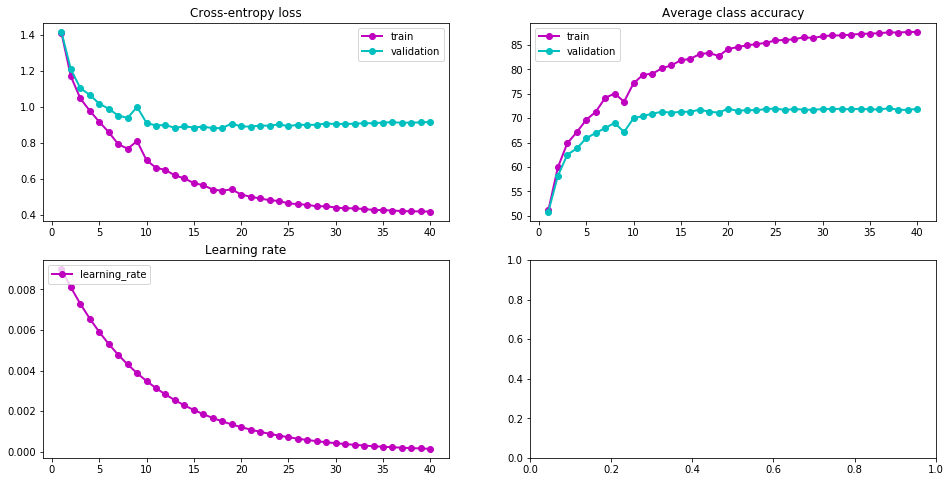

In [93]:
plot_training_progress(plot_data)

## TOP 20 worst samples

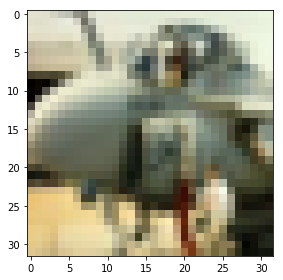

Correct class: airplane
Predictions: ['horse' 'cat' 'dog'] [  9.99739468e-01   9.74641371e-05   8.75552141e-05]


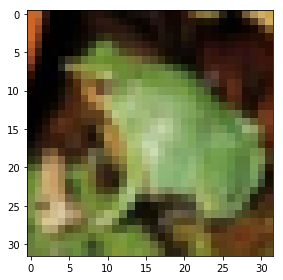

Correct class: cat
Predictions: ['frog' 'bird' 'deer'] [  9.99967933e-01   2.01723269e-05   6.18917466e-06]


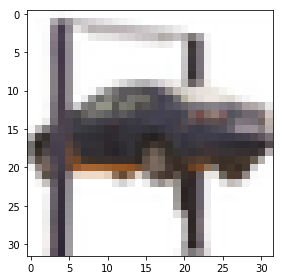

Correct class: automobile
Predictions: ['cat' 'bird' 'airplane'] [ 0.36930302  0.27390957  0.19647795]


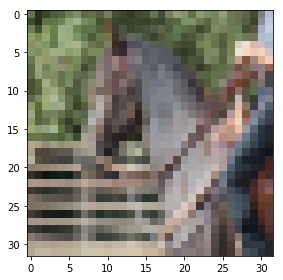

Correct class: horse
Predictions: ['bird' 'cat' 'frog'] [ 0.80542415  0.15984803  0.02156841]


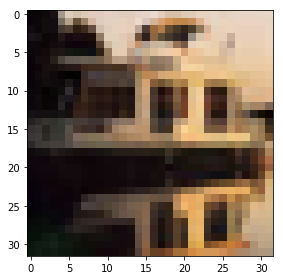

Correct class: ship
Predictions: ['horse' 'truck' 'automobile'] [ 0.54567158  0.44412461  0.00595216]


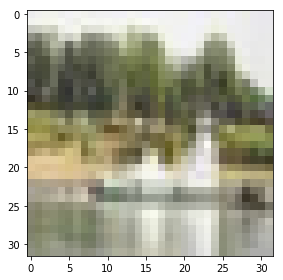

Correct class: ship
Predictions: ['horse' 'deer' 'cat'] [  9.80924249e-01   1.85880158e-02   2.54482380e-04]


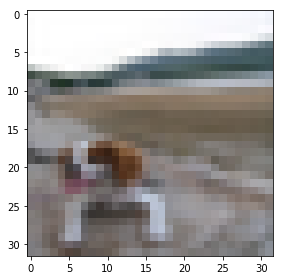

Correct class: dog
Predictions: ['airplane' 'ship' 'bird'] [ 0.96621758  0.01631741  0.01473842]


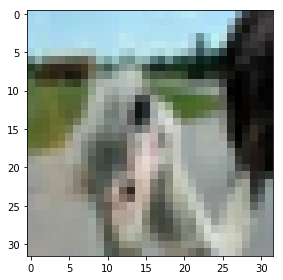

Correct class: bird
Predictions: ['dog' 'cat' 'horse'] [ 0.47077549  0.19616599  0.19369781]


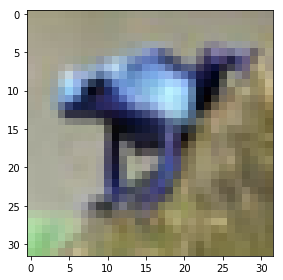

Correct class: frog
Predictions: ['horse' 'bird' 'dog'] [ 0.87164414  0.10383365  0.01343391]


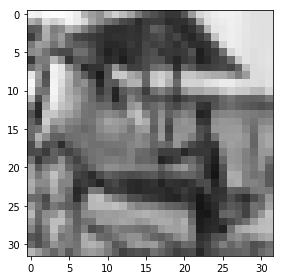

Correct class: airplane
Predictions: ['truck' 'cat' 'automobile'] [ 0.98806775  0.00313511  0.00250824]


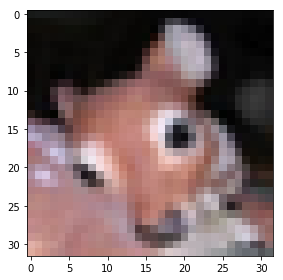

Correct class: deer
Predictions: ['dog' 'frog' 'horse'] [ 0.98990017  0.00438304  0.00317229]


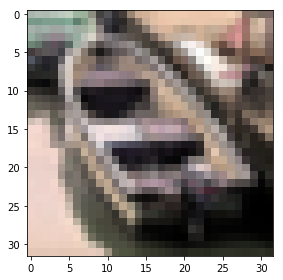

Correct class: ship
Predictions: ['automobile' 'bird' 'cat'] [ 0.81574732  0.13052218  0.04060157]


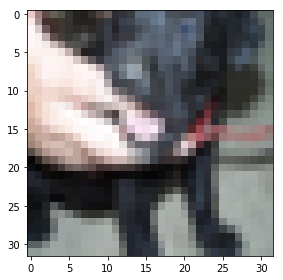

Correct class: dog
Predictions: ['deer' 'bird' 'airplane'] [ 0.67643625  0.16384377  0.14045107]


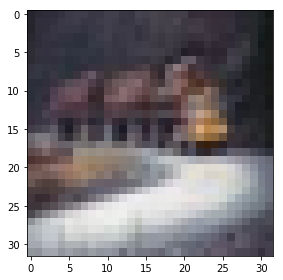

Correct class: truck
Predictions: ['ship' 'cat' 'airplane'] [  9.98607337e-01   9.56409203e-04   1.60390948e-04]


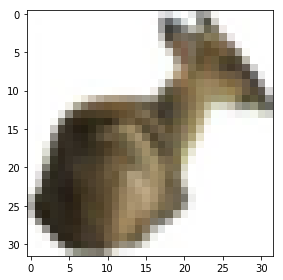

Correct class: deer
Predictions: ['cat' 'dog' 'horse'] [ 0.76926351  0.11822023  0.08392049]


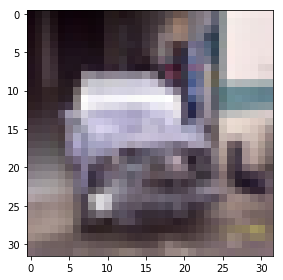

Correct class: automobile
Predictions: ['truck' 'horse' 'dog'] [  9.84286904e-01   1.51919518e-02   3.53193784e-04]


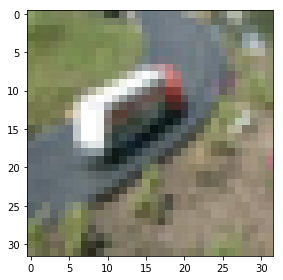

Correct class: truck
Predictions: ['bird' 'dog' 'horse'] [  9.98521388e-01   6.92658476e-04   2.98972009e-04]


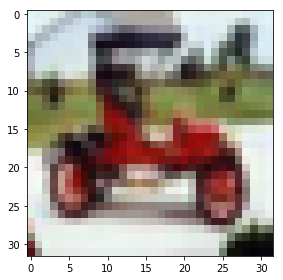

Correct class: automobile
Predictions: ['truck' 'cat' 'horse'] [ 0.9849745   0.0131389   0.00147518]


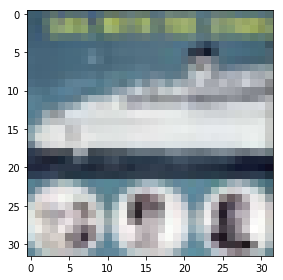

Correct class: ship
Predictions: ['airplane' 'truck' 'deer'] [ 0.98544532  0.00985646  0.00249108]


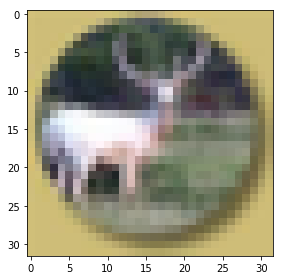

Correct class: deer
Predictions: ['automobile' 'truck' 'horse'] [ 0.99187875  0.00626307  0.00136699]


In [94]:
worst = worst_samples(session, test_x, test_y, config)

for sample_id, l, predicted in worst:
    show_image(test_x[sample_id], data_mean, data_std)
    probas = session.run(tf.nn.softmax(logits), feed_dict={X: np.array([test_x[sample_id]])})
    probas = probas[0]
    predictions  = np.argsort(-probas)

    print("Correct class:", class_names[test_y[sample_id]])
    print("Predictions:", class_names[predictions[:3]], probas[predictions[:3]])

## BONUS task - Multiclass hinge loss

In [95]:
def multi_class_hinge_loss(logits, label, n_classes, delta=10):
    label_oh = tf.one_hot(label, depth=n_classes, dtype=tf.float32)
    mask = 1-label_oh
    
    correct_logits = tf.diag(tf.reduce_sum(label_oh * logits, 1))
    correct_logits_mat = tf.matmul(correct_logits, tf.ones_like(logits))
    
    errors = tf.nn.relu(logits - correct_logits_mat + delta)
    return errors * mask

In [96]:
# Graph
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
Y_ = tf.placeholder(tf.int32, [None,])
logits = convnet(X, weights, biases)

# loss
regularizers = l2_loss(weights.values())
loss_per_sample = multi_class_hinge_loss(logits, Y_, n_classes)
data_loss = tf.reduce_mean(loss_per_sample)
loss = data_loss + weight_decay*regularizers


global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.01, global_step, 900, 0.9, staircase=True)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

In [97]:
session = tf.Session()
train_start = time.time()

plot_data={}
train_cifar(session, train_x, train_y, valid_x, valid_y, config, plot_data)

print("Total train time:", time.time() - train_start)

epoch 1, step 50 / 900, loss = 7.51 (0.007 sec/batch)
epoch 1, step 100 / 900, loss = 6.23 (0.006 sec/batch)


C:\Users\Korisnik\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


epoch 1, step 150 / 900, loss = 4.86 (0.006 sec/batch)
epoch 1, step 200 / 900, loss = 4.44 (0.006 sec/batch)
epoch 1, step 250 / 900, loss = 4.82 (0.008 sec/batch)
epoch 1, step 300 / 900, loss = 4.16 (0.007 sec/batch)
epoch 1, step 350 / 900, loss = 4.65 (0.008 sec/batch)
epoch 1, step 400 / 900, loss = 3.61 (0.009 sec/batch)
epoch 1, step 450 / 900, loss = 3.45 (0.007 sec/batch)
epoch 1, step 500 / 900, loss = 3.54 (0.007 sec/batch)
epoch 1, step 550 / 900, loss = 3.37 (0.008 sec/batch)
epoch 1, step 600 / 900, loss = 2.82 (0.008 sec/batch)
epoch 1, step 650 / 900, loss = 2.56 (0.007 sec/batch)
epoch 1, step 700 / 900, loss = 3.11 (0.007 sec/batch)
epoch 1, step 750 / 900, loss = 2.81 (0.006 sec/batch)
epoch 1, step 800 / 900, loss = 4.42 (0.007 sec/batch)
epoch 1, step 850 / 900, loss = 3.11 (0.007 sec/batch)
epoch 1, step 900 / 900, loss = 3.24 (0.009 sec/batch)
Train error:
 accuracy = 50.23
 avg loss = 2.92

Validation error:
 accuracy = 48.92
 avg loss = 2.98

Epoch time: 9.073

 accuracy = 72.02
 avg loss = 1.31

Validation error:
 accuracy = 67.40
 avg loss = 1.72

Epoch time: 9.067446231842041
Plotting in:  C:\Users\Korisnik\Desktop\du_lab2\Deep-Learning\2_lab\zad4_images\training_plot.pdf
epoch 8, step 50 / 900, loss = 1.05 (0.009 sec/batch)
epoch 8, step 100 / 900, loss = 1.60 (0.009 sec/batch)
epoch 8, step 150 / 900, loss = 0.85 (0.007 sec/batch)
epoch 8, step 200 / 900, loss = 1.44 (0.007 sec/batch)
epoch 8, step 250 / 900, loss = 1.64 (0.007 sec/batch)
epoch 8, step 300 / 900, loss = 1.91 (0.007 sec/batch)
epoch 8, step 350 / 900, loss = 0.67 (0.007 sec/batch)
epoch 8, step 400 / 900, loss = 1.88 (0.006 sec/batch)
epoch 8, step 450 / 900, loss = 1.30 (0.009 sec/batch)
epoch 8, step 500 / 900, loss = 1.71 (0.009 sec/batch)
epoch 8, step 550 / 900, loss = 1.36 (0.007 sec/batch)
epoch 8, step 600 / 900, loss = 2.08 (0.007 sec/batch)
epoch 8, step 650 / 900, loss = 1.00 (0.007 sec/batch)
epoch 8, step 700 / 900, loss = 1.22 (0.007 sec/batch)
epoch 8, step

epoch 14, step 600 / 900, loss = 0.66 (0.008 sec/batch)
epoch 14, step 650 / 900, loss = 0.92 (0.007 sec/batch)
epoch 14, step 700 / 900, loss = 0.82 (0.008 sec/batch)
epoch 14, step 750 / 900, loss = 0.69 (0.006 sec/batch)
epoch 14, step 800 / 900, loss = 0.67 (0.007 sec/batch)
epoch 14, step 850 / 900, loss = 0.66 (0.007 sec/batch)
epoch 14, step 900 / 900, loss = 0.80 (0.007 sec/batch)
Train error:
 accuracy = 79.63
 avg loss = 0.84

Validation error:
 accuracy = 70.74
 avg loss = 1.55

Epoch time: 9.249760389328003
Plotting in:  C:\Users\Korisnik\Desktop\du_lab2\Deep-Learning\2_lab\zad4_images\training_plot.pdf
epoch 15, step 50 / 900, loss = 1.07 (0.007 sec/batch)
epoch 15, step 100 / 900, loss = 1.18 (0.007 sec/batch)
epoch 15, step 150 / 900, loss = 0.68 (0.007 sec/batch)
epoch 15, step 200 / 900, loss = 1.01 (0.006 sec/batch)
epoch 15, step 250 / 900, loss = 0.65 (0.007 sec/batch)
epoch 15, step 300 / 900, loss = 0.66 (0.007 sec/batch)
epoch 15, step 350 / 900, loss = 0.66 (0.0

epoch 21, step 200 / 900, loss = 0.65 (0.009 sec/batch)
epoch 21, step 250 / 900, loss = 0.57 (0.008 sec/batch)
epoch 21, step 300 / 900, loss = 0.53 (0.007 sec/batch)
epoch 21, step 350 / 900, loss = 0.91 (0.007 sec/batch)
epoch 21, step 400 / 900, loss = 0.28 (0.008 sec/batch)
epoch 21, step 450 / 900, loss = 0.50 (0.006 sec/batch)
epoch 21, step 500 / 900, loss = 0.60 (0.007 sec/batch)
epoch 21, step 550 / 900, loss = 0.46 (0.007 sec/batch)
epoch 21, step 600 / 900, loss = 0.44 (0.007 sec/batch)
epoch 21, step 650 / 900, loss = 0.60 (0.007 sec/batch)
epoch 21, step 700 / 900, loss = 0.60 (0.007 sec/batch)
epoch 21, step 750 / 900, loss = 0.53 (0.006 sec/batch)
epoch 21, step 800 / 900, loss = 0.66 (0.007 sec/batch)
epoch 21, step 850 / 900, loss = 0.59 (0.007 sec/batch)
epoch 21, step 900 / 900, loss = 0.68 (0.006 sec/batch)
Train error:
 accuracy = 83.66
 avg loss = 0.63

Validation error:
 accuracy = 71.74
 avg loss = 1.51

Epoch time: 9.025930404663086
Plotting in:  C:\Users\Kori

epoch 27, step 900 / 900, loss = 0.64 (0.007 sec/batch)
Train error:
 accuracy = 85.08
 avg loss = 0.57

Validation error:
 accuracy = 71.58
 avg loss = 1.53

Epoch time: 9.036214828491211
Plotting in:  C:\Users\Korisnik\Desktop\du_lab2\Deep-Learning\2_lab\zad4_images\training_plot.pdf
epoch 28, step 50 / 900, loss = 0.67 (0.006 sec/batch)
epoch 28, step 100 / 900, loss = 0.71 (0.007 sec/batch)
epoch 28, step 150 / 900, loss = 0.36 (0.008 sec/batch)
epoch 28, step 200 / 900, loss = 0.79 (0.007 sec/batch)
epoch 28, step 250 / 900, loss = 0.65 (0.006 sec/batch)
epoch 28, step 300 / 900, loss = 0.45 (0.007 sec/batch)
epoch 28, step 350 / 900, loss = 0.28 (0.007 sec/batch)
epoch 28, step 400 / 900, loss = 0.34 (0.010 sec/batch)
epoch 28, step 450 / 900, loss = 0.75 (0.007 sec/batch)
epoch 28, step 500 / 900, loss = 0.54 (0.006 sec/batch)
epoch 28, step 550 / 900, loss = 0.53 (0.007 sec/batch)
epoch 28, step 600 / 900, loss = 0.42 (0.007 sec/batch)
epoch 28, step 650 / 900, loss = 0.35 (0.0

epoch 34, step 500 / 900, loss = 0.37 (0.009 sec/batch)
epoch 34, step 550 / 900, loss = 0.53 (0.007 sec/batch)
epoch 34, step 600 / 900, loss = 0.50 (0.007 sec/batch)
epoch 34, step 650 / 900, loss = 0.60 (0.007 sec/batch)
epoch 34, step 700 / 900, loss = 0.28 (0.008 sec/batch)
epoch 34, step 750 / 900, loss = 0.64 (0.007 sec/batch)
epoch 34, step 800 / 900, loss = 0.56 (0.007 sec/batch)
epoch 34, step 850 / 900, loss = 0.81 (0.008 sec/batch)
epoch 34, step 900 / 900, loss = 0.34 (0.006 sec/batch)
Train error:
 accuracy = 86.17
 avg loss = 0.52

Validation error:
 accuracy = 71.80
 avg loss = 1.52

Epoch time: 9.538930177688599
Plotting in:  C:\Users\Korisnik\Desktop\du_lab2\Deep-Learning\2_lab\zad4_images\training_plot.pdf
epoch 35, step 50 / 900, loss = 0.44 (0.007 sec/batch)
epoch 35, step 100 / 900, loss = 0.26 (0.007 sec/batch)
epoch 35, step 150 / 900, loss = 0.46 (0.008 sec/batch)
epoch 35, step 200 / 900, loss = 0.40 (0.007 sec/batch)
epoch 35, step 250 / 900, loss = 0.49 (0.0

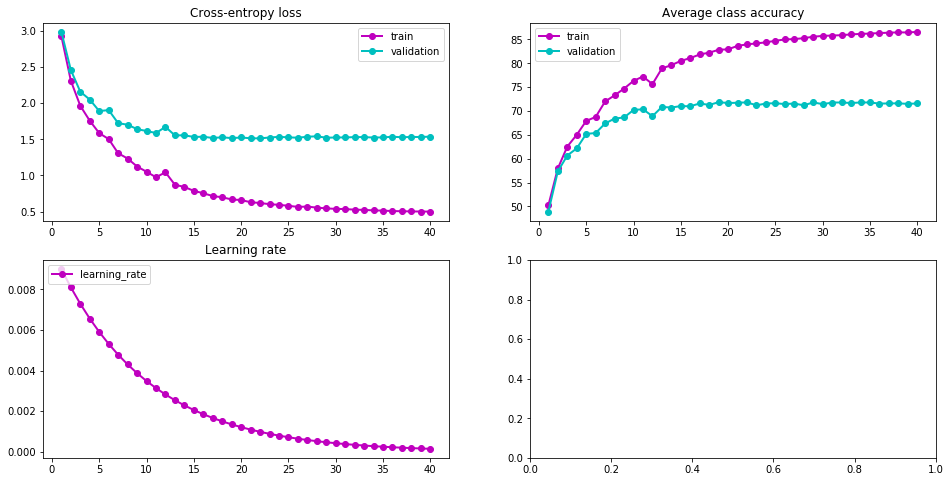

In [98]:
plot_training_progress(plot_data)

## AdaGrad optimizer

In [111]:
# Graph
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
Y_ = tf.placeholder(tf.int32, [None,])
logits = convnet(X, weights, biases)

# loss
regularizers = l2_loss(weights.values())
loss_per_sample = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=Y_)
data_loss = tf.reduce_mean(loss_per_sample)
loss = data_loss + weight_decay*regularizers


global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.01, global_step, 900, 0.9, staircase=True)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

In [112]:
session = tf.Session()
train_start = time.time()

plot_data={}
train_cifar(session, train_x, train_y, valid_x, valid_y, config, plot_data)

print("Total train time:", time.time() - train_start)

epoch 1, step 50 / 900, loss = 2.28 (0.006 sec/batch)
epoch 1, step 100 / 900, loss = 1.71 (0.007 sec/batch)


C:\Users\Korisnik\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


epoch 1, step 150 / 900, loss = 1.97 (0.008 sec/batch)
epoch 1, step 200 / 900, loss = 1.77 (0.007 sec/batch)
epoch 1, step 250 / 900, loss = 1.66 (0.007 sec/batch)
epoch 1, step 300 / 900, loss = 1.56 (0.006 sec/batch)
epoch 1, step 350 / 900, loss = 1.55 (0.006 sec/batch)
epoch 1, step 400 / 900, loss = 1.78 (0.006 sec/batch)
epoch 1, step 450 / 900, loss = 1.55 (0.006 sec/batch)
epoch 1, step 500 / 900, loss = 1.40 (0.009 sec/batch)
epoch 1, step 550 / 900, loss = 1.33 (0.007 sec/batch)
epoch 1, step 600 / 900, loss = 1.31 (0.006 sec/batch)
epoch 1, step 650 / 900, loss = 1.39 (0.006 sec/batch)
epoch 1, step 700 / 900, loss = 1.24 (0.008 sec/batch)
epoch 1, step 750 / 900, loss = 1.41 (0.007 sec/batch)
epoch 1, step 800 / 900, loss = 1.26 (0.008 sec/batch)
epoch 1, step 850 / 900, loss = 1.49 (0.007 sec/batch)
epoch 1, step 900 / 900, loss = 1.35 (0.008 sec/batch)
Train error:
 accuracy = 56.42
 avg loss = 1.26

Validation error:
 accuracy = 55.68
 avg loss = 1.29

Epoch time: 9.518

 accuracy = 77.42
 avg loss = 0.70

Validation error:
 accuracy = 69.34
 avg loss = 0.92

Epoch time: 9.489799499511719
Plotting in:  C:\Users\Korisnik\Desktop\du_lab2\Deep-Learning\2_lab\zad4_images\training_plot.pdf
epoch 8, step 50 / 900, loss = 0.69 (0.007 sec/batch)
epoch 8, step 100 / 900, loss = 0.60 (0.008 sec/batch)
epoch 8, step 150 / 900, loss = 0.71 (0.008 sec/batch)
epoch 8, step 200 / 900, loss = 0.63 (0.009 sec/batch)
epoch 8, step 250 / 900, loss = 0.68 (0.009 sec/batch)
epoch 8, step 300 / 900, loss = 0.60 (0.008 sec/batch)
epoch 8, step 350 / 900, loss = 0.60 (0.007 sec/batch)
epoch 8, step 400 / 900, loss = 0.69 (0.006 sec/batch)
epoch 8, step 450 / 900, loss = 0.63 (0.007 sec/batch)
epoch 8, step 500 / 900, loss = 0.82 (0.006 sec/batch)
epoch 8, step 550 / 900, loss = 0.75 (0.006 sec/batch)
epoch 8, step 600 / 900, loss = 0.54 (0.006 sec/batch)
epoch 8, step 650 / 900, loss = 0.51 (0.007 sec/batch)
epoch 8, step 700 / 900, loss = 0.88 (0.008 sec/batch)
epoch 8, step

epoch 14, step 600 / 900, loss = 0.55 (0.006 sec/batch)
epoch 14, step 650 / 900, loss = 0.65 (0.008 sec/batch)
epoch 14, step 700 / 900, loss = 0.48 (0.010 sec/batch)
epoch 14, step 750 / 900, loss = 0.58 (0.007 sec/batch)
epoch 14, step 800 / 900, loss = 0.62 (0.006 sec/batch)
epoch 14, step 850 / 900, loss = 0.30 (0.007 sec/batch)
epoch 14, step 900 / 900, loss = 0.62 (0.008 sec/batch)
Train error:
 accuracy = 83.88
 avg loss = 0.53

Validation error:
 accuracy = 72.06
 avg loss = 0.87

Epoch time: 9.401389122009277
Plotting in:  C:\Users\Korisnik\Desktop\du_lab2\Deep-Learning\2_lab\zad4_images\training_plot.pdf
epoch 15, step 50 / 900, loss = 0.39 (0.007 sec/batch)
epoch 15, step 100 / 900, loss = 0.73 (0.006 sec/batch)
epoch 15, step 150 / 900, loss = 0.44 (0.007 sec/batch)
epoch 15, step 200 / 900, loss = 0.52 (0.006 sec/batch)
epoch 15, step 250 / 900, loss = 0.61 (0.007 sec/batch)
epoch 15, step 300 / 900, loss = 0.27 (0.007 sec/batch)
epoch 15, step 350 / 900, loss = 0.54 (0.0

epoch 21, step 200 / 900, loss = 0.47 (0.007 sec/batch)
epoch 21, step 250 / 900, loss = 0.55 (0.011 sec/batch)
epoch 21, step 300 / 900, loss = 0.32 (0.006 sec/batch)
epoch 21, step 350 / 900, loss = 0.34 (0.006 sec/batch)
epoch 21, step 400 / 900, loss = 0.60 (0.008 sec/batch)
epoch 21, step 450 / 900, loss = 0.45 (0.007 sec/batch)
epoch 21, step 500 / 900, loss = 0.53 (0.008 sec/batch)
epoch 21, step 550 / 900, loss = 0.47 (0.007 sec/batch)
epoch 21, step 600 / 900, loss = 0.46 (0.007 sec/batch)
epoch 21, step 650 / 900, loss = 0.47 (0.008 sec/batch)
epoch 21, step 700 / 900, loss = 0.57 (0.008 sec/batch)
epoch 21, step 750 / 900, loss = 0.33 (0.006 sec/batch)
epoch 21, step 800 / 900, loss = 0.39 (0.007 sec/batch)
epoch 21, step 850 / 900, loss = 0.44 (0.007 sec/batch)
epoch 21, step 900 / 900, loss = 0.48 (0.007 sec/batch)
Train error:
 accuracy = 86.26
 avg loss = 0.46

Validation error:
 accuracy = 71.64
 avg loss = 0.87

Epoch time: 9.465367555618286
Plotting in:  C:\Users\Kori

epoch 27, step 900 / 900, loss = 0.53 (0.008 sec/batch)
Train error:
 accuracy = 87.43
 avg loss = 0.44

Validation error:
 accuracy = 71.98
 avg loss = 0.87

Epoch time: 9.328996181488037
Plotting in:  C:\Users\Korisnik\Desktop\du_lab2\Deep-Learning\2_lab\zad4_images\training_plot.pdf
epoch 28, step 50 / 900, loss = 0.60 (0.010 sec/batch)
epoch 28, step 100 / 900, loss = 0.50 (0.009 sec/batch)
epoch 28, step 150 / 900, loss = 0.28 (0.006 sec/batch)
epoch 28, step 200 / 900, loss = 0.49 (0.008 sec/batch)
epoch 28, step 250 / 900, loss = 0.37 (0.006 sec/batch)
epoch 28, step 300 / 900, loss = 0.44 (0.013 sec/batch)
epoch 28, step 350 / 900, loss = 0.39 (0.007 sec/batch)
epoch 28, step 400 / 900, loss = 0.57 (0.008 sec/batch)
epoch 28, step 450 / 900, loss = 0.56 (0.007 sec/batch)
epoch 28, step 500 / 900, loss = 0.53 (0.008 sec/batch)
epoch 28, step 550 / 900, loss = 0.45 (0.008 sec/batch)
epoch 28, step 600 / 900, loss = 0.33 (0.008 sec/batch)
epoch 28, step 650 / 900, loss = 0.42 (0.0

epoch 34, step 500 / 900, loss = 0.28 (0.008 sec/batch)
epoch 34, step 550 / 900, loss = 0.40 (0.009 sec/batch)
epoch 34, step 600 / 900, loss = 0.37 (0.007 sec/batch)
epoch 34, step 650 / 900, loss = 0.42 (0.007 sec/batch)
epoch 34, step 700 / 900, loss = 0.44 (0.008 sec/batch)
epoch 34, step 750 / 900, loss = 0.49 (0.008 sec/batch)
epoch 34, step 800 / 900, loss = 0.28 (0.007 sec/batch)
epoch 34, step 850 / 900, loss = 0.42 (0.007 sec/batch)
epoch 34, step 900 / 900, loss = 0.47 (0.009 sec/batch)
Train error:
 accuracy = 87.95
 avg loss = 0.43

Validation error:
 accuracy = 71.94
 avg loss = 0.87

Epoch time: 9.360340595245361
Plotting in:  C:\Users\Korisnik\Desktop\du_lab2\Deep-Learning\2_lab\zad4_images\training_plot.pdf
epoch 35, step 50 / 900, loss = 0.26 (0.008 sec/batch)
epoch 35, step 100 / 900, loss = 0.36 (0.006 sec/batch)
epoch 35, step 150 / 900, loss = 0.32 (0.008 sec/batch)
epoch 35, step 200 / 900, loss = 0.49 (0.007 sec/batch)
epoch 35, step 250 / 900, loss = 0.51 (0.0

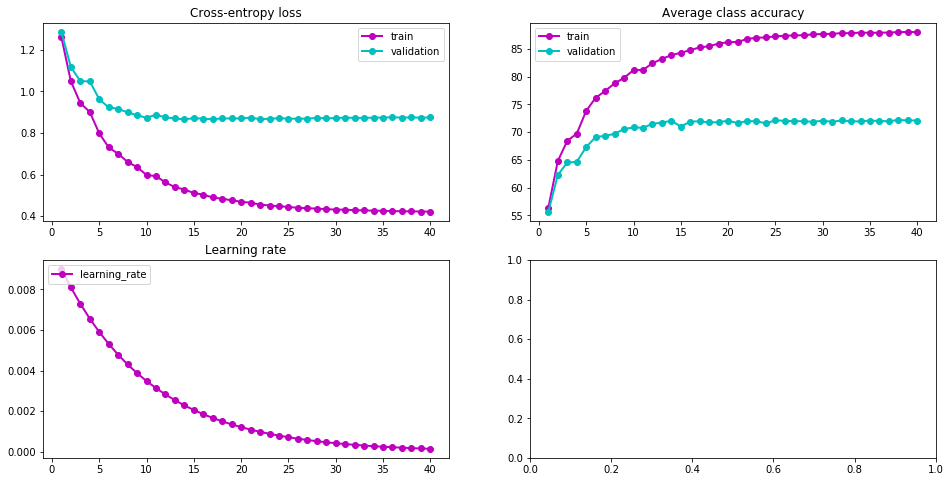

In [113]:
plot_training_progress(plot_data)

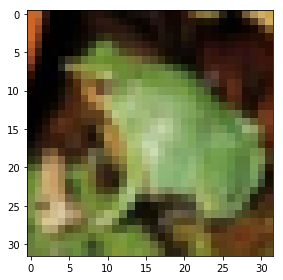

Correct class: cat
Predictions: ['frog' 'bird' 'dog'] [  9.99975562e-01   1.84183336e-05   2.21035884e-06]


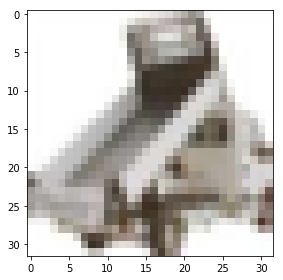

Correct class: truck
Predictions: ['dog' 'cat' 'bird'] [ 0.4655984   0.23260756  0.18337156]


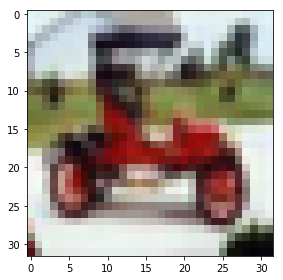

Correct class: automobile
Predictions: ['truck' 'horse' 'cat'] [  9.99833584e-01   1.34933565e-04   1.82403510e-05]


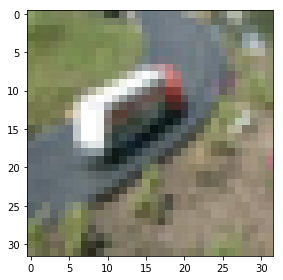

Correct class: truck
Predictions: ['bird' 'frog' 'airplane'] [  9.95070934e-01   3.39995022e-03   5.27196738e-04]


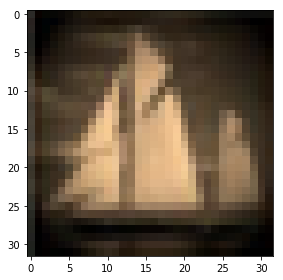

Correct class: ship
Predictions: ['dog' 'horse' 'cat'] [ 0.89723867  0.07807672  0.01602577]


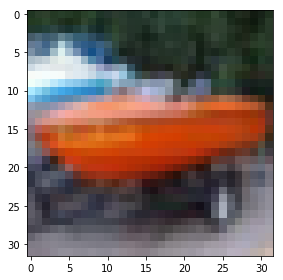

Correct class: ship
Predictions: ['automobile' 'truck' 'airplane'] [  9.75293100e-01   2.37451978e-02   9.44912841e-04]


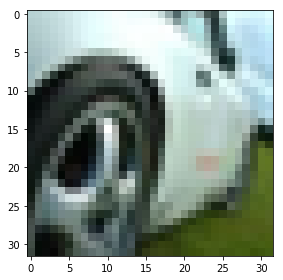

Correct class: automobile
Predictions: ['dog' 'cat' 'horse'] [ 0.7094292   0.23683818  0.04895716]


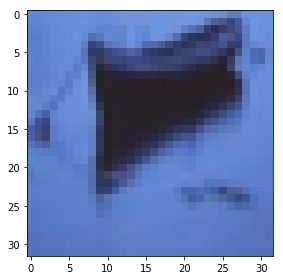

Correct class: ship
Predictions: ['airplane' 'bird' 'dog'] [ 0.9796896   0.0096837   0.00739191]


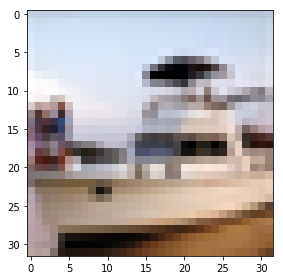

Correct class: ship
Predictions: ['airplane' 'truck' 'automobile'] [ 0.98922658  0.00726318  0.00324466]


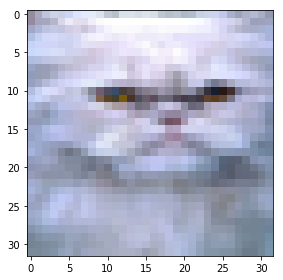

Correct class: cat
Predictions: ['airplane' 'ship' 'bird'] [ 0.6248529   0.37288868  0.00127298]


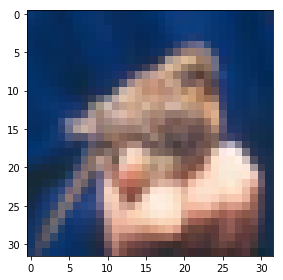

Correct class: bird
Predictions: ['dog' 'frog' 'ship'] [ 0.95125693  0.0277505   0.01826219]


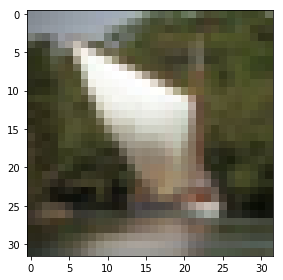

Correct class: ship
Predictions: ['horse' 'dog' 'cat'] [ 0.60634363  0.15830515  0.10272072]


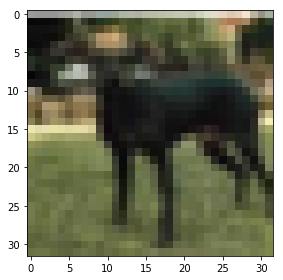

Correct class: dog
Predictions: ['horse' 'deer' 'automobile'] [  8.12025547e-01   1.87293738e-01   3.79140489e-04]


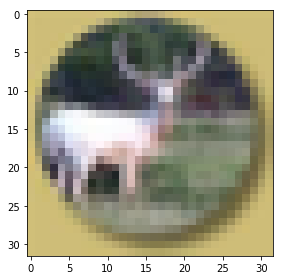

Correct class: deer
Predictions: ['automobile' 'horse' 'truck'] [  9.98405993e-01   1.11370184e-03   2.27105586e-04]


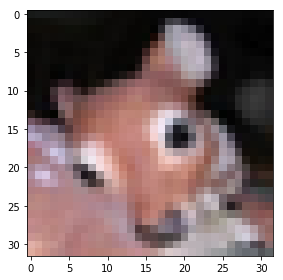

Correct class: deer
Predictions: ['dog' 'cat' 'frog'] [ 0.98430204  0.00717602  0.00645544]


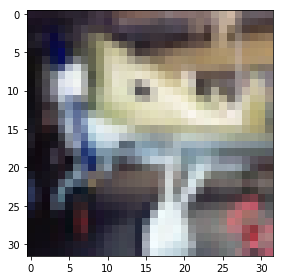

Correct class: airplane
Predictions: ['frog' 'cat' 'bird'] [ 0.84072846  0.07509656  0.03518334]


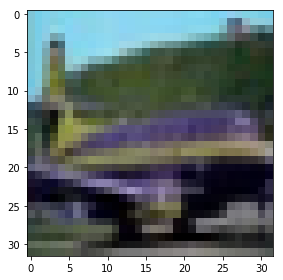

Correct class: airplane
Predictions: ['truck' 'automobile' 'airplane'] [  9.83287334e-01   1.65471770e-02   8.93738033e-05]


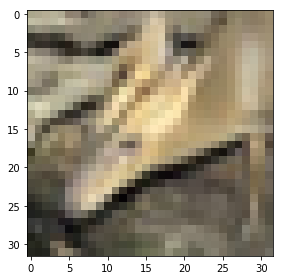

Correct class: deer
Predictions: ['bird' 'frog' 'airplane'] [ 0.70057923  0.29675242  0.0011694 ]


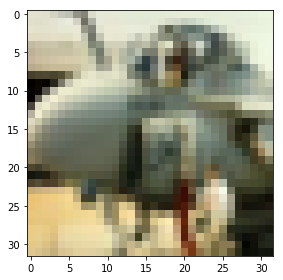

Correct class: airplane
Predictions: ['horse' 'cat' 'deer'] [ 0.96933293  0.02222641  0.00417694]


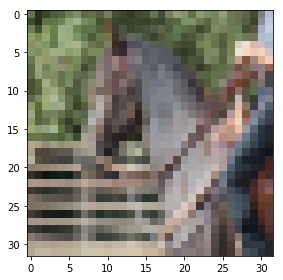

Correct class: horse
Predictions: ['cat' 'ship' 'bird'] [ 0.66969067  0.23040417  0.09729752]


In [114]:
worst = worst_samples(session, test_x, test_y, config)

for sample_id, l, predicted in worst:
    show_image(test_x[sample_id], data_mean, data_std)
    probas = session.run(tf.nn.softmax(logits), feed_dict={X: np.array([test_x[sample_id]])})
    probas = probas[0]
    predictions  = np.argsort(-probas)

    print("Correct class:", class_names[test_y[sample_id]])
    print("Predictions:", class_names[predictions[:3]], probas[predictions[:3]])